In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys
import matplotlib as mpl
from os import system
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import scipy.stats as stats
import phik 
import seaborn as sns
from phik import resources, report
from phik.report import plot_correlation_matrix
from itertools import combinations
import random
from tabulate import tabulate
from IPython.display import display, HTML
import graphviz
import networkx as nx
import itertools
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

In [2]:
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    matplotlib = __import__('matplotlib')

In [3]:
matplotlib.__version__

'3.5.3'

In [4]:

from graphviz import Digraph
gra = Digraph()
gra.node('a', 'Machine Learning Errors')

gra.node('b', 'RMSE')

gra.node('c', 'MAE')
gra.edges(['ab', 'ac'])

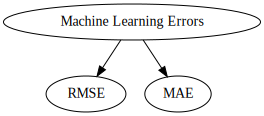

In [5]:
gra

In [6]:
print(gra.source)

digraph {
	a [label="Machine Learning Errors"]
	b [label=RMSE]
	c [label=MAE]
	a -> b
	a -> c
}


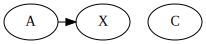

In [7]:
gra = Digraph()
with gra.subgraph() as i:

    i.attr(rank='same')

    i.node('A')

    i.node('X')

gra.node('C')
gra.edges(['AX'])
gra


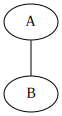

In [8]:
import graphviz
g = graphviz.Graph()
g.node('A')
g.node('B')
g.edge('A','B')
g

# load functions 
# load the datasets, set cutoff values, correlation method (these are done individually so the system saves them globallly)

In [9]:
gtex_toil_dataset = '../gtex_RSEM_gene_tpm.gz'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_toil_pancanc = "../gtex_and_tcga/tcga_RSEM_gene_tpm.gz"
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
tcga_toil_sampinfo = "../gtex_and_tcga/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
tcga_toil_clincinfo = "../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp"
opposing_corr_cutoff = 0.1


In [10]:
#functions for data processing
def gtex_data_processing(gtex_toil_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all = pd.read_csv(gtex_toil_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.set_index('sample').copy()

    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    gtex_breast_data_all.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    gtex_breast_data_all=gtex_breast_data_all.loc[gtex_breast_data_all.index.isin(list(gene_map.id.values))]
    gtex_breast_data_all=pd.concat([gtex_breast_data_all,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:gtex_breast_data_all.shape[1]]
    gtex_breast_data_all=gtex_breast_data_all.T.astype('float').copy()
    df_int = gtex_breast_data_all.copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    
    gtex_toil_phenotype = pd.read_csv('../GTEX_phenotype.gz',sep='\t')
    #subset for breast
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype['body_site_detail (SMTSD)']=='Breast - Mammary Tissue']
    #subset for female gender
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype._gender=='female']

    #select breast female gtex gene expression data
    df_int=df_int.loc[df_int.index.isin(gtex_toil_phenotype.Sample.values)].copy()
    
    return df_int

def tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    #tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
 
    #separate normal and primtum (remember primary tumor contains multiple stages)
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients = tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients = tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 


    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients._PATIENT.values:
        if patient in tcga_brca_normal_patients._PATIENT.values and patient in ['-'.join(patient_id.split('-')[0:3]) for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info._PATIENT==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    # matched_patient_id_list=pd.Index(tcga_brca_normal_patients['_PATIENT']).intersection(pd.Index(tcga_brca_primtum_patients['_PATIENT']))
    # matched_patient_index_list=tcga_brca_sample_info[tcga_brca_sample_info._PATIENT.isin(matched_patient_id_list)].index.values
    # matched_patient_list = tcga_brca_sample_info.loc[[l for l in matched_patient_index_list]].copy()
    # #ensure samples are present in tcga_brca_df
    # matched_patient_list=matched_patient_list.loc[matched_patient_list.index.intersection(pd.Index(tcga_brca_df.columns))]

    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')

    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

def correlation_selected_gene(provided_dataset,interest_gene,correlation_method):
    dataset_corr = provided_dataset.corrwith(provided_dataset[interest_gene],
                                             method=correlation_method).drop(interest_gene)
    dataset_corr = dataset_corr.dropna(axis=0,how='any')
    idx = dataset_corr.index.drop_duplicates(keep=False)
    dataset_corr = dataset_corr.loc[idx]
    return dataset_corr
def pairwise_pearson_correlation(provided_dataset):
    #columns have to be variables and rows have to be observations
    pairwise_corr=pd.DataFrame(np.corrcoef(provided_dataset,rowvar=False),
                               columns=provided_dataset.columns,index=provided_dataset.columns)



In [11]:
def early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    

    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']
    
    #stage I and II only
    #early_stages=['Stage IIB', 'Stage IA','Stage IIA','Stage I','Stage IB','Stage II']    
    
    #stage I only
    early_stages=[ 'Stage IA','Stage I','Stage IB']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(early_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary early stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_early_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_early_stage':tcga_brca_df_primtum_early_stage}

def late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]    
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    
    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info

    late_stages=['Stage IIIA', 'Stage IV','Stage IIIC','Stage IIIB','Stage III']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(late_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary late stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_late_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_late_stage':tcga_brca_df_primtum_late_stage}


In [12]:
#functions for counting
def count_genes_3_no_overlap(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    names = [first_dataset_name,second_dataset_name,third_dataset_name]
    j=0
    for dataset in [gtex_dataset,dataset2,dataset3]:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[names[j]]=dataset.shape[0]
        j+=1
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'corr_with_{interest_gene}'])
    return display(HTML(dict_pd_df.to_html()))    
def count_genes_same_3(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(dataset2,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index).intersection(dataset3.index)
    global new_dataset
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                             dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,second_dataset_name,third_dataset_name]
    print("1st: common genes identified for all 3 datasets\n2nd: they were counted")
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,second_dataset_name,third_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[input(f'insert name for {j+1}th dataset')]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df
def cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: High cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: low cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_highgtex_low_other'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))

def cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset,
                                    dataset3):
#dataset3 MUST BE tcga primtum all
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= (gtex_dataset.index.intersection(dataset2.index)).intersection(dataset3.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                            dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name='tcga_normal_all'
    dataset3_name = 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,other_dataset_name,dataset3_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other datasets\n3rd: all datasets combined\n4th: High cutoff applied to non-gtex datasets")
    
    new_dataset = new_dataset[(new_dataset[other_dataset_name]>=correlation_cutoff) & (new_dataset[dataset3_name]>=correlation_cutoff)]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,other_dataset_name,dataset3_name])
    return dict_pd_df



In [13]:
#organize as a table (original way -- before Jesse finalized the presentation but i used this for table 2)
# careful of the #ered data (e.g. #3 is #3 in both functions but presentation might be different)
def make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #1
    count_genes_3_no_overlap(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #2
    count_genes_same_3(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    #9
    cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    return

In [14]:
#table 1
def organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    number_5=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    nnumber_7=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    number_10=cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all,
                                    tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%also_highly_correlated_in_TCGA_normal'
    fourth_column_name='%also_highly_correlated_in_TCGA_primtum'
    fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_5.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_5.iloc[0,0])})',
                                     str(format((nnumber_7.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(nnumber_7.iloc[0,0])})',
                                     str(format((number_10.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_10.iloc[0,0])})',
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

def organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    number_6=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    number_8=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_TCGA_primtum'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

#table 3
def organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    
    gtex_expression_mean = df_int[interest_gene].mean()
    gtex_expression_stdev= df_int[interest_gene].std()
    
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3_tcga_normal=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_primtum_all')
    number_3_tcga_primtum=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    

    first_column_name='Integrin' #index
    second_column_name='GTEX_expression_mean_&_stdev'
    third_column_name='GTEX_highly_correlated'
    fourth_column_name='highly_correlated_in_TCGA_normal'
    fifth_column_name='highly_corelated_in_TCGA_primtum'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[f'{format(gtex_expression_mean,"0.2f")} + {format(gtex_expression_stdev,"0.2f")}',
                                     str(number_3_tcga_normal.iloc[0,0]),
                                     str(number_3_tcga_normal.iloc[0,1]),
                                     str(number_3_tcga_primtum.iloc[0,1])]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
def organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
#designed for custom changes to helper functions in below cell (way down below)
#some helper functions appear twice because too many input variables so i made changes 
#changes in same cell as table 4 function
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('its TCGA_primtum_all')

    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,'tcga_primtum',tcga_brca_df_primtum_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('common gene list applied to all')
    print('high tcga_primtum and low tcga normal')        
    number_6=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              tcga_brca_df_normal_all,tcga_brca_df_primtum_all,'tcga_normal')
    #8
    print('high tcga_primtum and low gtex')                
    number_8=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              df_int,tcga_brca_df_primtum_all,'gtex_all')
    #9a
    print('high tcga primtum, high gtex')
    number_9a = cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='TCGA_tumor_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_gtex'
    fifth_column_name = '%highly_corelated_in_gtex'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})',
                                     str(format((number_9a.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_9a.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
    


In [15]:
#files loading
df_int=gtex_data_processing(gtex_toil_dataset)
tcga_data=tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)
tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched=tcga_data['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched=tcga_data['tcga_brca_df_primtum_matched']
tcga_brca_df_primtum_early_stage=early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_early_stage']
tcga_brca_df_primtum_late_stage=late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_late_stage']


before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158


In [16]:
tcga_brca_df_normal_matched

,TCGA-E2-A153-11,TCGA-BH-A0BQ-11,TCGA-BH-A204-11,TCGA-E9-A1RF-11,TCGA-A7-A13F-11,TCGA-AC-A23H-11,TCGA-BH-A0HA-11,TCGA-A7-A0CE-11,TCGA-BH-A0HK-11,TCGA-BH-A0B7-11,...,TCGA-BH-A18K-11,TCGA-E2-A1IG-11,TCGA-BH-A0DG-11,TCGA-BH-A1FM-11,TCGA-BH-A1FC-11,TCGA-BH-A0H7-11,TCGA-BH-A1F0-11,TCGA-BH-A1EN-11,TCGA-E9-A1RC-11,TCGA-E2-A15K-11
gene,,,,,,,,,,,,,,,,,,,,,
RAB4B,5.1776,4.4108,3.8876,3.7950,4.2987,3.1028,3.6950,5.2799,4.5274,4.4122,...,4.3206,4.6041,4.0713,4.2419,5.0562,4.3681,4.4027,4.3499,4.3716,5.2747
TIGAR,3.0056,2.3077,1.9340,1.9601,2.1247,0.8726,1.2576,2.3564,2.9784,2.3677,...,2.0183,3.1095,2.1114,2.7951,3.0654,1.3109,2.5288,2.3704,1.9786,1.3623
RNF44,4.6972,4.5349,2.9090,2.9765,4.1343,3.3407,4.7016,4.0858,4.0216,4.7442,...,4.7613,4.0952,4.3328,3.9496,4.1078,3.8993,3.9431,3.6994,3.1765,3.7550
DNAH3,-1.7322,-1.5951,-5.0116,-4.2934,-5.0116,-2.3884,-5.0116,-3.4580,-5.0116,-2.6349,...,-2.0529,-2.4659,-2.8262,-1.9942,-2.9324,-3.3076,-5.0116,-5.0116,-6.5064,-9.9658
RPL23A,10.0921,10.5473,9.9437,9.9067,10.4163,11.0965,10.9753,10.7251,10.7876,10.8137,...,10.5153,10.2721,10.9925,10.5979,10.3529,10.3948,10.4049,10.1203,9.6112,10.2819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CYP4F2,-3.6259,-9.9658,-9.9658,-9.9658,-5.0116,-4.6082,-6.5064,-6.5064,-3.8160,-3.3076,...,-3.6259,-9.9658,-6.5064,-9.9658,-5.5735,0.6239,-4.0350,-9.9658,-9.9658,-9.9658
TENM1,-1.8836,-0.6643,-0.6193,0.7664,-1.0862,-1.5522,-0.7346,-3.0469,-1.9379,-0.9686,...,-1.3548,-1.6850,-1.0862,-2.8262,-3.1714,-3.6259,-2.7274,-2.1779,-0.4325,-3.3076
BATF3,0.8164,1.7403,1.8119,1.8762,1.1250,0.5955,0.1257,2.3394,2.8158,-0.0725,...,1.1250,1.3109,0.5666,1.3511,2.6255,0.6239,1.2209,1.5950,0.9789,2.0360


In [17]:
#test
test_df_int=correlation_selected_gene(df_int,interest_gene,correlation_method)
test_tcga_brca_df_normal_all=correlation_selected_gene(tcga_brca_df_normal_all,interest_gene,correlation_method)
test_tcga_brca_df_primtum_all=correlation_selected_gene(tcga_brca_df_primtum_all,interest_gene,correlation_method)

NameError: name 'interest_gene' is not defined

In [ ]:
test_df_int[test_df_int>=correlation_cutoff]

In [ ]:
#dataset_corr = dataset_corr.dropna(axis=0,how='any')
    #idx = dataset_corr.index.drop_duplicates(keep=False)
    #dataset_corr = dataset_corr.loc[idx]

# heatmap for expression vs integrin

In [16]:
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

heatmap_df.mean()


gene
ITGA10    3.579545
ITGAD    -4.286682
ITGAM     2.159924
ITGA3     5.095033
ITGBL1    3.315321
ITGAE     4.753785
ITGA2     1.586592
ITGB3     2.067059
ITGA7     6.832596
ITGB8     2.448926
ITGAX     2.543840
ITGAV     4.190931
ITGB6     2.636786
ITGB7     1.100666
ITGA5     6.266535
ITGB4     6.259103
ITGB2     4.027357
ITGA6     5.557185
ITGA2B    0.320877
ITGB1     7.546813
ITGAL     1.844824
ITGA9     2.375535
ITGB5     6.504485
ITGA8     0.581589
ITGA4     1.541030
ITGA1     3.824854
ITGA11    1.867581
dtype: float64

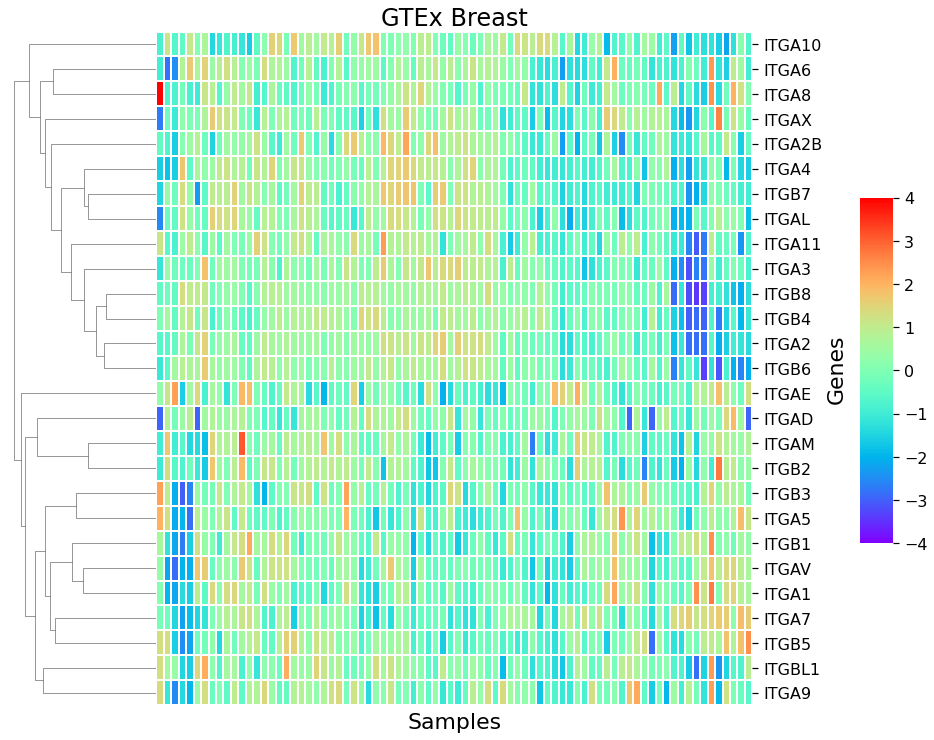

In [17]:
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()

ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', linewidths=0.01, 
                    fmt='', figsize=(15,12), annot_kws={"size": 20}, vmin=-4,vmax=4, xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('GTEx Breast',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Genes', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/gtex_breast_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df

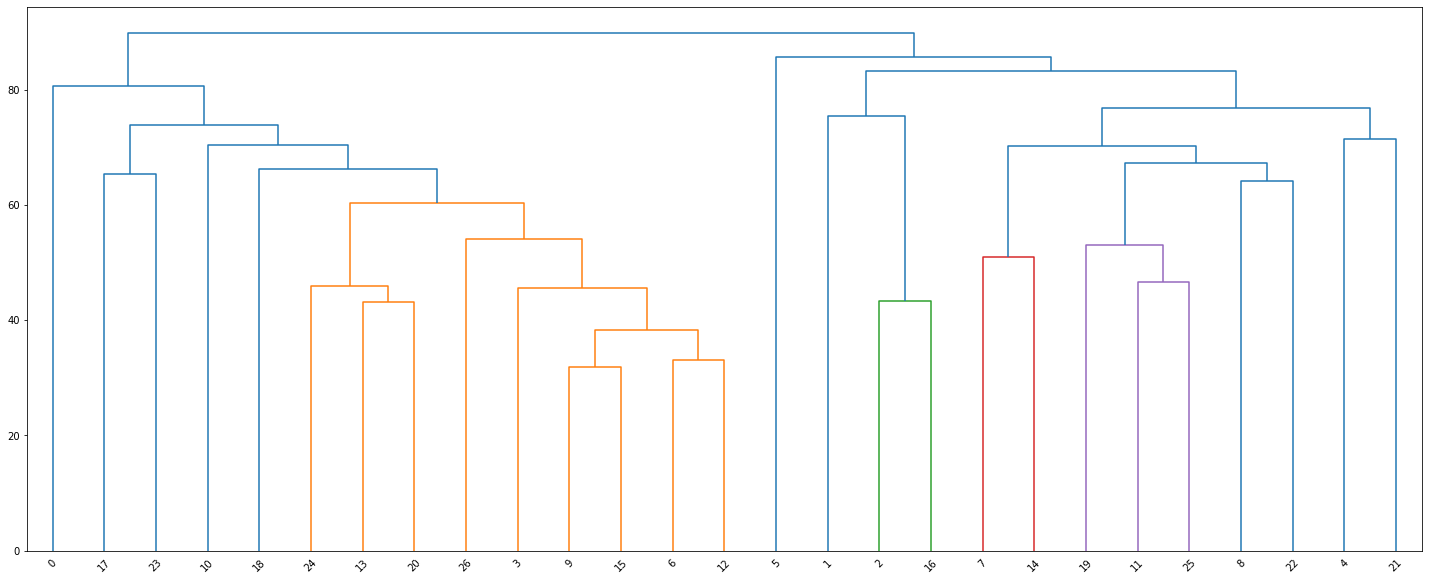

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


Z = linkage(heatmap_df.T, method='average',metric='cityblock')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [19]:
heatmap_df.T

,GTEX-X4EP-2926-SM-3P5YQ,GTEX-11P81-1926-SM-5BC53,GTEX-13FTY-2226-SM-5J1ND,GTEX-S32W-2026-SM-4AD6E,GTEX-13O3O-0826-SM-5K7WE,GTEX-13QIC-2326-SM-5LU5N,GTEX-VJWN-0726-SM-3GIJ8,GTEX-131YS-0626-SM-5EGKL,GTEX-T6MO-0326-SM-32QOK,GTEX-11ILO-2226-SM-5A5L1,...,GTEX-XMD2-0926-SM-4WWEF,GTEX-X15G-1626-SM-3NMB3,GTEX-13N11-1726-SM-5J1OJ,GTEX-ZQG8-0726-SM-5P9H9,GTEX-YB5K-1626-SM-5IFIN,GTEX-R53T-1526-SM-48FEK,GTEX-ZAJG-0626-SM-5HL8X,GTEX-ZXES-0826-SM-5E43C,GTEX-TML8-1226-SM-32QON,GTEX-1117F-2826-SM-5GZXL
gene,,,,,,,,,,,,,,,,,,,,,
ITGA10,-0.407825,0.206165,0.317064,0.152313,-0.598202,0.215747,0.008583,0.060653,1.429021,-1.108054,...,-0.537294,0.410878,0.340759,-1.738237,-0.449273,-1.602009,0.457451,1.794919,-0.887816,0.548814
ITGAD,1.096666,1.025524,-1.154357,0.509169,-0.669206,-0.669206,-2.953408,0.509169,-1.154357,0.430954,...,0.946892,-0.376991,0.810900,-1.154357,-0.376991,-0.003493,-2.953408,0.704291,0.704291,-1.154357
ITGAM,-0.016997,0.270978,-1.618788,0.395243,0.027413,0.420620,-1.400187,-0.146779,-0.385930,0.748867,...,-0.296145,0.163263,0.661427,0.794105,-1.753811,0.130163,-0.451855,-0.316833,0.935334,-1.540036
ITGA3,1.386876,0.124908,1.576113,-0.265413,-0.017671,0.831298,0.015988,0.561165,-0.811023,0.470302,...,-0.520089,0.858022,0.776982,-3.185736,-2.473423,-0.139158,-0.326662,0.965497,0.560731,-0.362632
ITGBL1,0.107071,0.724102,0.374155,-0.805496,0.900103,0.206267,1.417722,0.238936,-0.331147,-0.731071,...,0.214489,0.127407,-0.244499,-1.675982,-0.746216,0.311197,-0.129617,1.300244,0.583907,0.253648
ITGAE,-1.398414,-0.251085,-0.340370,-0.253091,-1.165003,-0.377154,1.386476,-0.238043,-0.352074,0.296664,...,-0.578463,-1.106148,1.475427,-0.721587,-0.176514,1.867345,-0.279509,-0.159793,-0.053788,-0.243728
ITGA2,0.587124,0.902859,1.542303,-1.172527,-0.259301,0.982741,1.102564,0.516840,0.493154,0.286250,...,-0.085914,0.509796,0.519162,-2.817154,-1.110525,-0.420536,-0.110296,0.469003,0.647035,-0.431373
ITGB3,1.412143,-0.748991,1.174700,0.614691,0.712382,-1.954253,0.353105,-1.188908,0.079946,1.066805,...,0.063394,-0.257179,0.317514,-0.611353,-0.433768,0.574620,0.281300,-0.179774,0.732418,1.593835
ITGA7,-1.231495,0.271145,-0.681213,1.862947,-1.327973,-0.718137,-1.497788,-1.053513,0.736350,0.438833,...,-0.632293,0.006044,-0.061253,1.602355,1.465550,1.220186,-1.385570,-1.783138,0.707849,-0.526627


/home/hshadman/.local/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


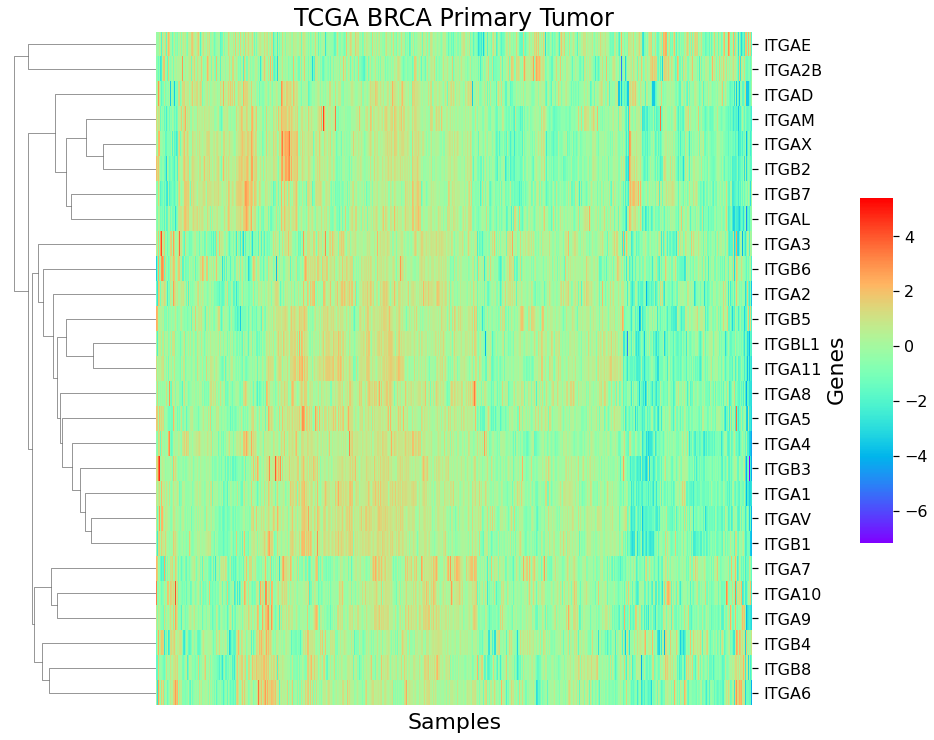

In [20]:
heatmap_df = tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains('ITG')]]

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


#no linewidths entry in here, too many samples for TCGA BRCA
ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', 
                    fmt='', figsize=(15,12), annot_kws={"size": 20},  xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('TCGA BRCA Primary Tumor',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Genes', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/tcga_brca_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df


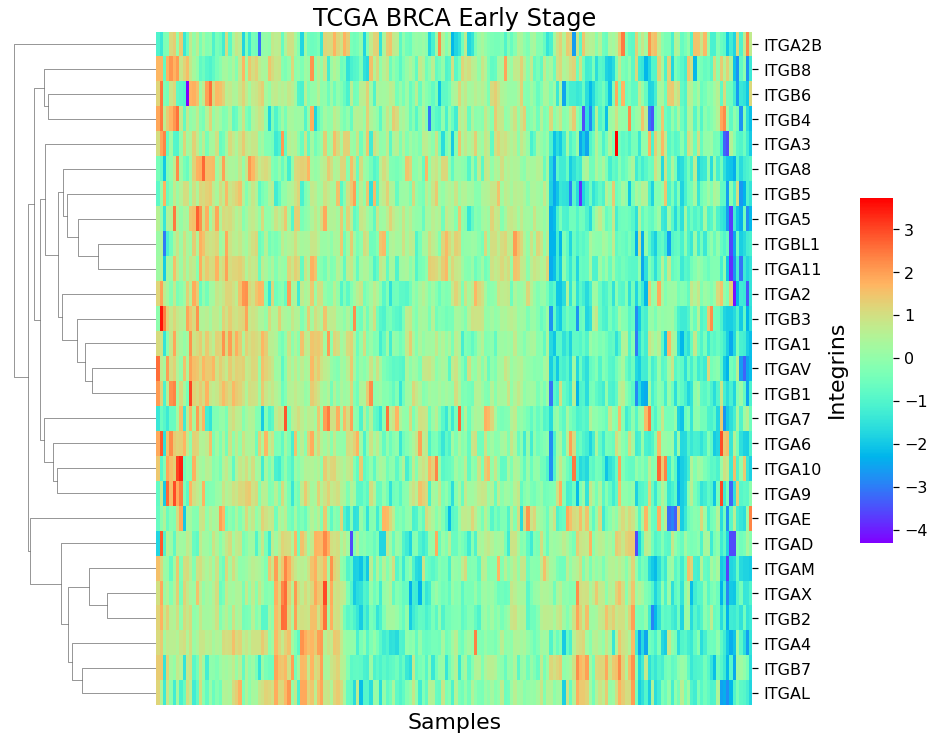

In [28]:
heatmap_df = tcga_brca_df_primtum_early_stage[tcga_brca_df_primtum_early_stage.columns[tcga_brca_df_primtum_early_stage.columns.str.contains('ITG')]]

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


#no linewidths entry in here, too many samples for TCGA BRCA
ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', 
                    fmt='', figsize=(15,12), annot_kws={"size": 20},  xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('TCGA BRCA Early Stage',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Integrins', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/tcga_brca_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df


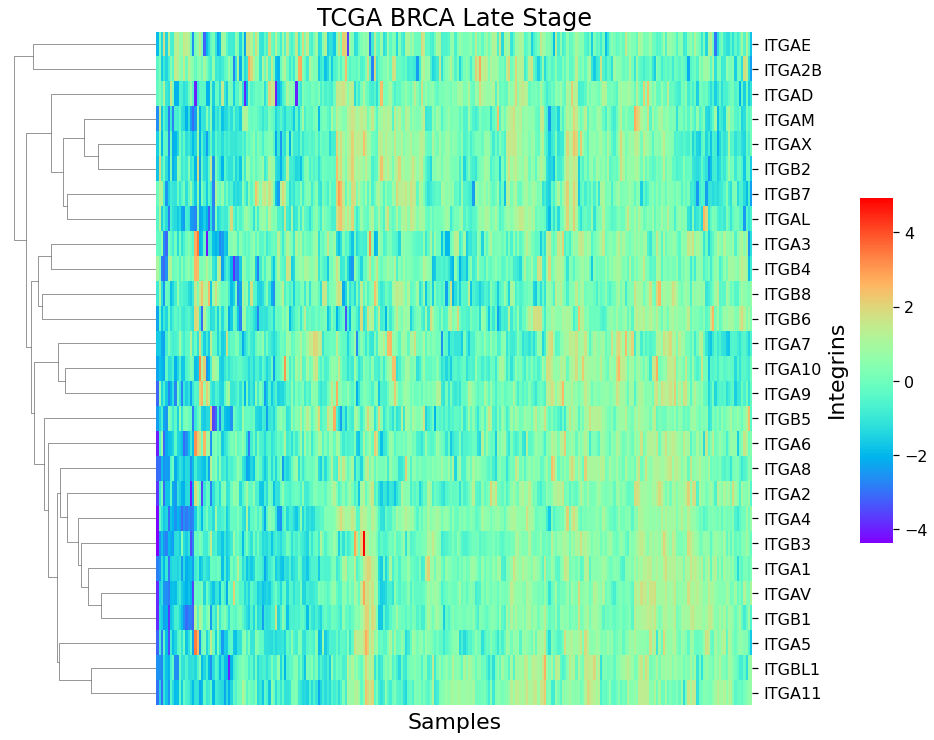

In [27]:
heatmap_df = tcga_brca_df_primtum_late_stage[tcga_brca_df_primtum_late_stage.columns[tcga_brca_df_primtum_late_stage.columns.str.contains('ITG')]]

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


#no linewidths entry in here, too many samples for TCGA BRCA
ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', 
                    fmt='', figsize=(15,12), annot_kws={"size": 20},  xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('TCGA BRCA Late Stage',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Integrins', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/tcga_brca_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df


# Expression plots of integrins in early vs late stage

In [17]:
early_stage_ITG = tcga_brca_df_primtum_early_stage[tcga_brca_df_primtum_early_stage.columns[tcga_brca_df_primtum_early_stage.columns.str.contains('ITG')]]
late_stage_ITG = tcga_brca_df_primtum_late_stage[tcga_brca_df_primtum_late_stage.columns[tcga_brca_df_primtum_late_stage.columns.str.contains('ITG')]]
late_stage_ITG.mean()


gene
ITGA10    0.100136
ITGAD    -2.787524
ITGAM     2.277450
ITGA3     4.719803
ITGBL1    4.523366
ITGAE     4.519921
ITGA2     2.666899
ITGB3     0.578164
ITGA7     2.172767
ITGB8     1.222891
ITGAX     2.471422
ITGAV     4.806929
ITGB6     3.453891
ITGB7     1.670104
ITGA5     5.287131
ITGB4     5.323311
ITGB2     5.158947
ITGA6     4.325154
ITGA2B   -1.193282
ITGB1     7.872147
ITGAL     2.969097
ITGA9     1.462769
ITGB5     7.050366
ITGA8     0.127885
ITGA4     1.538752
ITGA1     2.932165
ITGA11    3.379414
dtype: float64

In [18]:
late_stage_ITG

gene,ITGA10,ITGAD,ITGAM,ITGA3,ITGBL1,ITGAE,ITGA2,ITGB3,ITGA7,ITGB8,...,ITGA6,ITGA2B,ITGB1,ITGAL,ITGA9,ITGB5,ITGA8,ITGA4,ITGA1,ITGA11
TCGA-AC-A6IX-06,1.496200,-1.510500,3.653200,5.0627,3.182900,5.037400,3.295900,-1.055900,3.060200,1.546500,...,4.242700,-1.469900,7.552300,4.691000,2.417100,8.128400,2.744400,3.418300,3.034000,1.022200
TCGA-E2-A15A-06,-0.471900,0.323100,2.627800,4.9542,3.534900,5.713700,3.391100,-1.055900,1.816000,-2.547900,...,3.228200,-0.664300,8.258400,4.928900,1.516500,6.344300,2.039500,3.495800,3.957100,3.779400
TCGA-A2-A25D-01,-1.685000,-3.046900,1.664900,4.2442,3.356300,3.961700,0.125700,-0.432500,2.296000,-1.392100,...,3.542400,-2.826200,7.015800,3.660000,1.714100,5.533600,-0.249800,1.541500,2.347900,1.646600
TCGA-AC-A3W6-01,1.269600,-1.685000,2.961800,3.9022,6.575300,4.369500,2.070700,0.614500,4.218100,1.811900,...,4.925100,-1.732200,7.820900,4.191500,2.242100,8.613900,1.744600,1.748900,2.939400,5.059200
TCGA-BH-A1F8-01,-0.619300,-5.011600,1.293400,3.9118,4.855000,5.263400,4.011800,0.071800,-0.267100,0.401600,...,4.737700,-1.732200,9.042400,2.592400,0.614500,6.161900,0.001400,1.748900,2.630200,3.610100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A1HO-01,-0.267100,-1.994200,0.623900,5.2013,4.683800,3.768800,0.633200,-0.134500,1.091500,-2.727400,...,4.356900,-4.608200,8.021700,2.236000,0.151900,6.173100,0.240000,1.064200,2.765700,3.347800
TCGA-PL-A8LZ-01,1.799500,-3.307600,2.653300,4.0850,4.034000,4.272800,2.720500,2.101300,3.673700,1.433500,...,7.060900,-1.510500,8.168500,4.311900,2.183000,6.147100,0.880500,2.689500,4.598800,4.060100
TCGA-S3-A6ZH-01,4.708200,-3.307600,0.872600,4.8187,1.852400,4.250300,2.043000,-0.452100,1.709700,0.190300,...,5.767900,0.816400,7.733300,4.973700,0.334600,7.294400,-1.248100,1.373500,1.820100,1.480800
TCGA-AR-A0TQ-01,-1.148800,-1.510500,2.299000,5.3615,2.982000,4.518000,3.112900,0.688000,1.884000,-0.512500,...,4.325600,-0.710800,7.931300,4.090100,1.138200,8.694400,-0.452100,2.345100,3.266200,1.982200


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


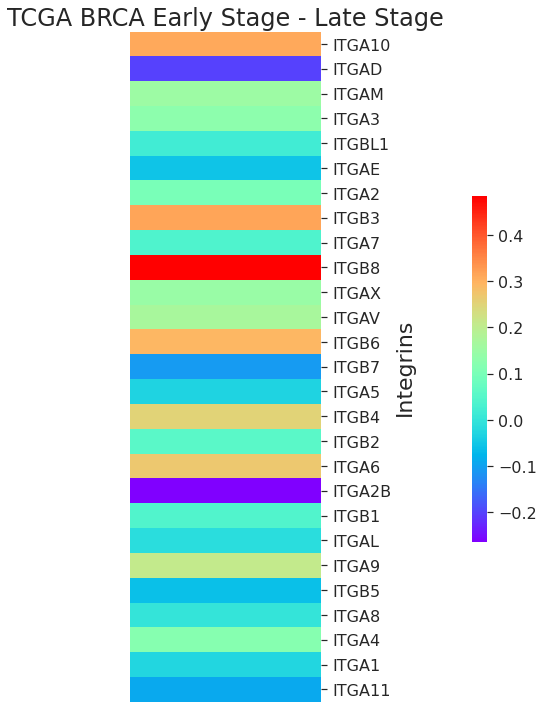

In [133]:

heatmap_df = early_stage_ITG.mean()-late_stage_ITG.mean()

#convert to Z-score
#heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


#no linewidths entry in here, too many samples for TCGA BRCA
ax = sns.clustermap(heatmap_df, cmap='rainbow', row_cluster=False, col_cluster=False,
                    method='average', metric='cityblock', 
                    fmt='', figsize=(7,12), annot_kws={"size": 20},  xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('TCGA BRCA Early Stage - Late Stage',fontsize=24)
#ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Integrins', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.5)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(False) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/tcga_brca_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df

plt.tight_layout()


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


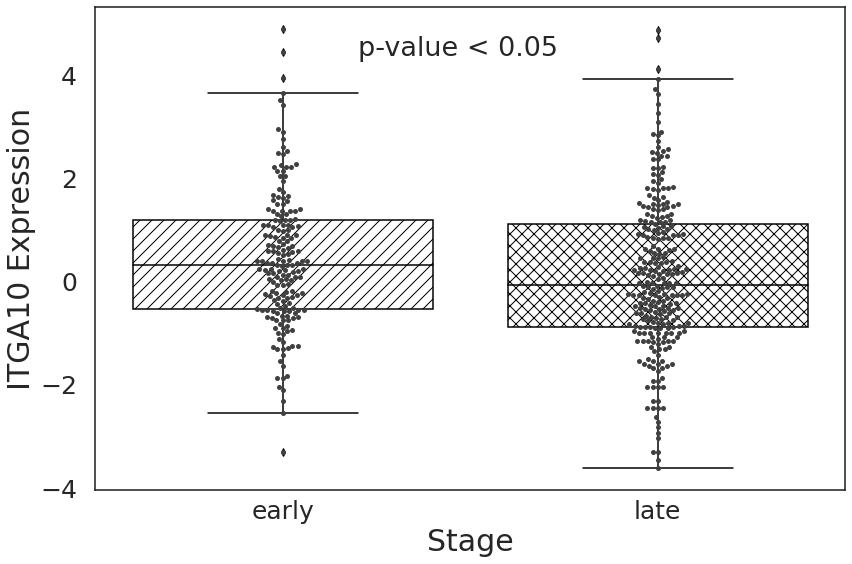

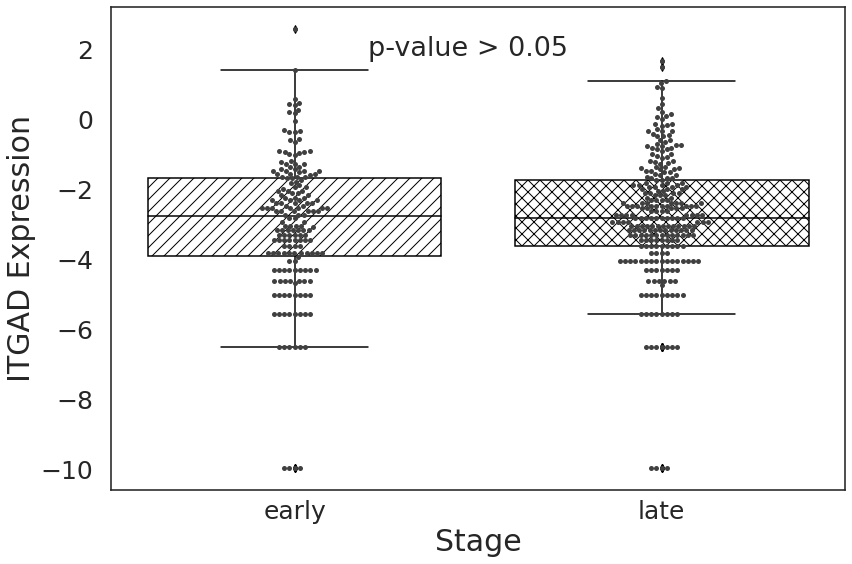

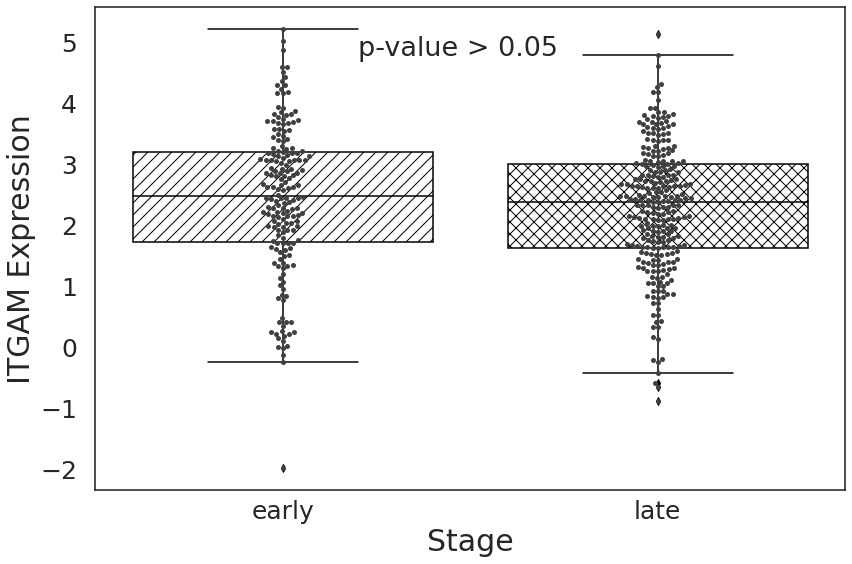

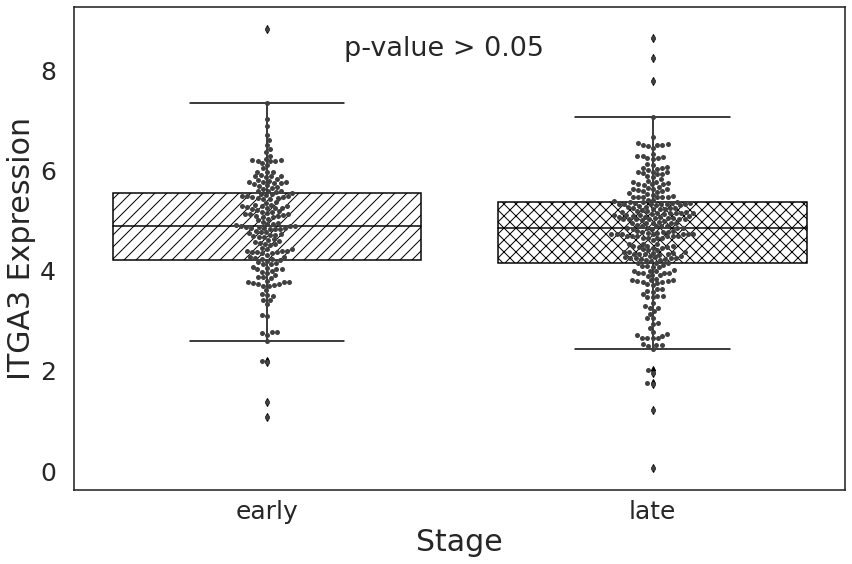

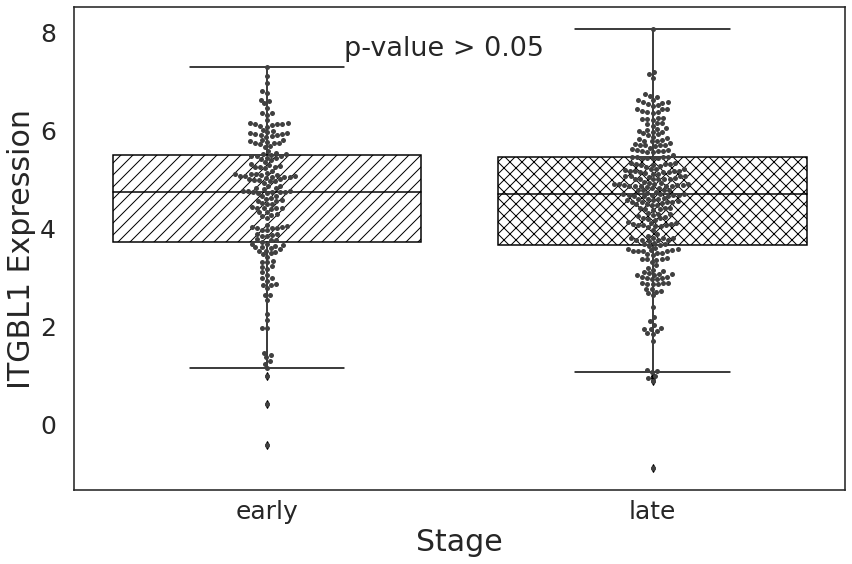

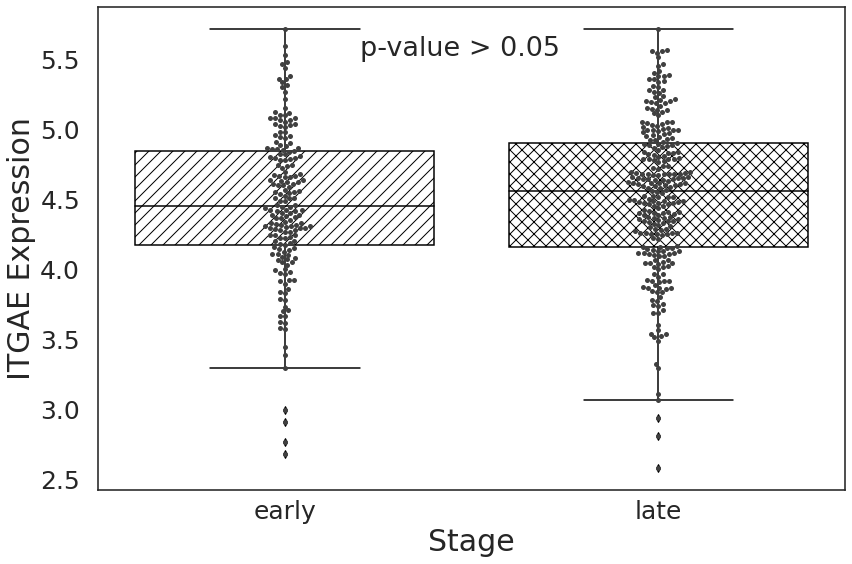

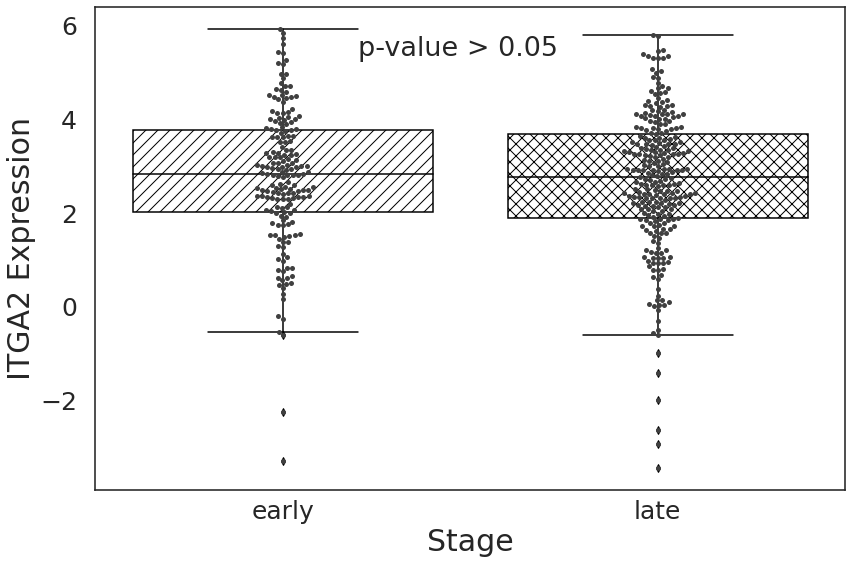

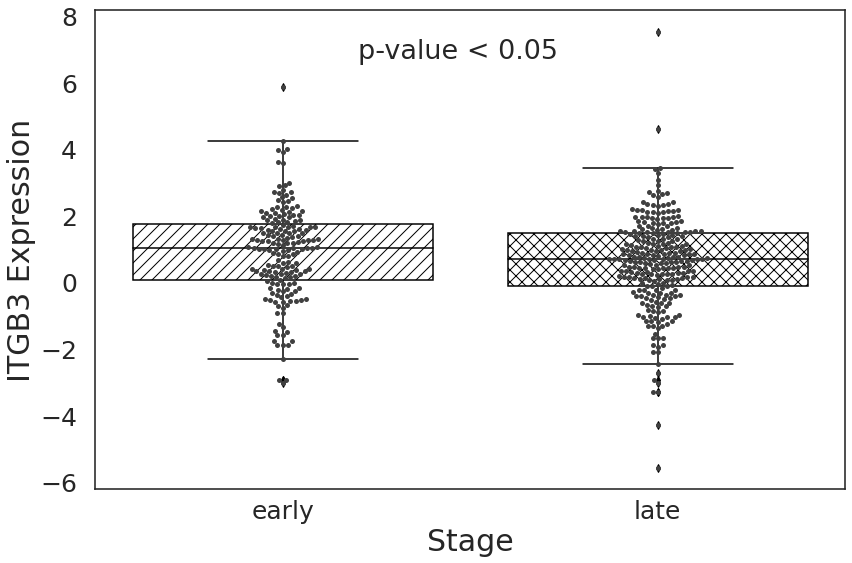

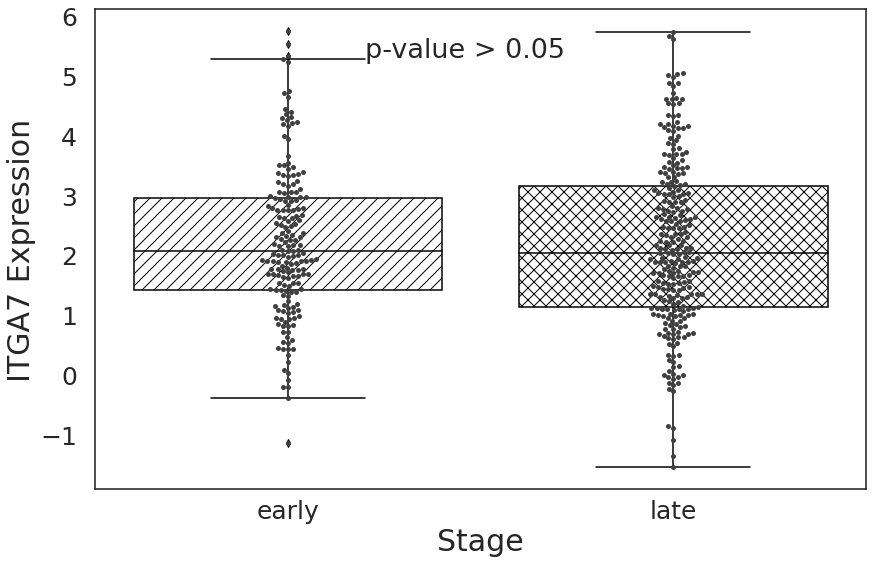

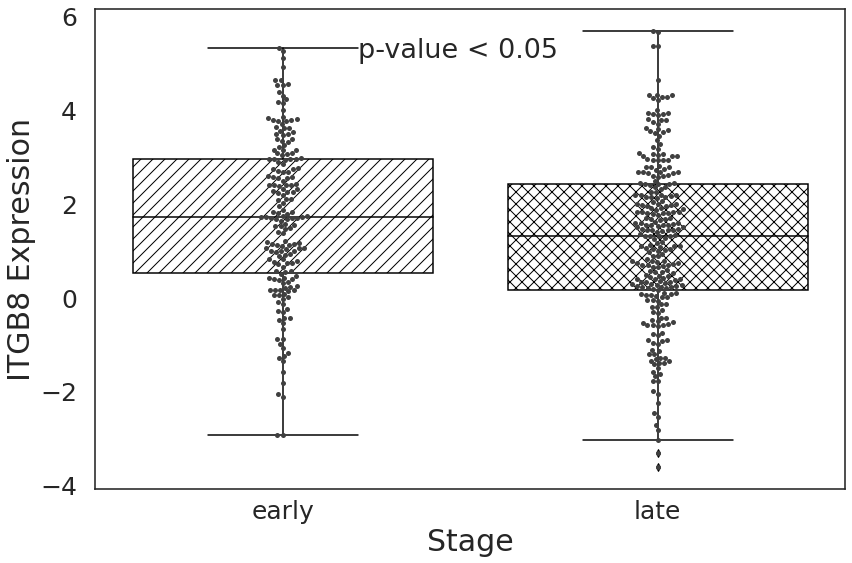

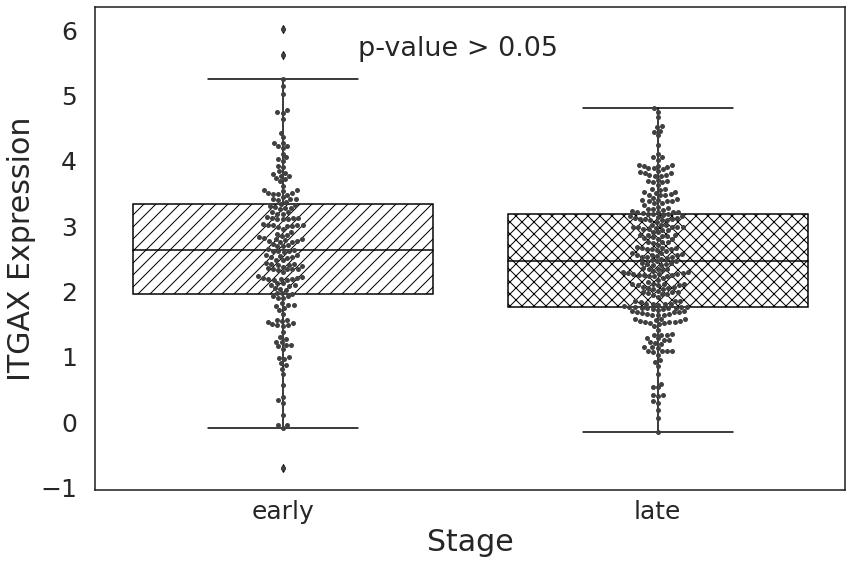

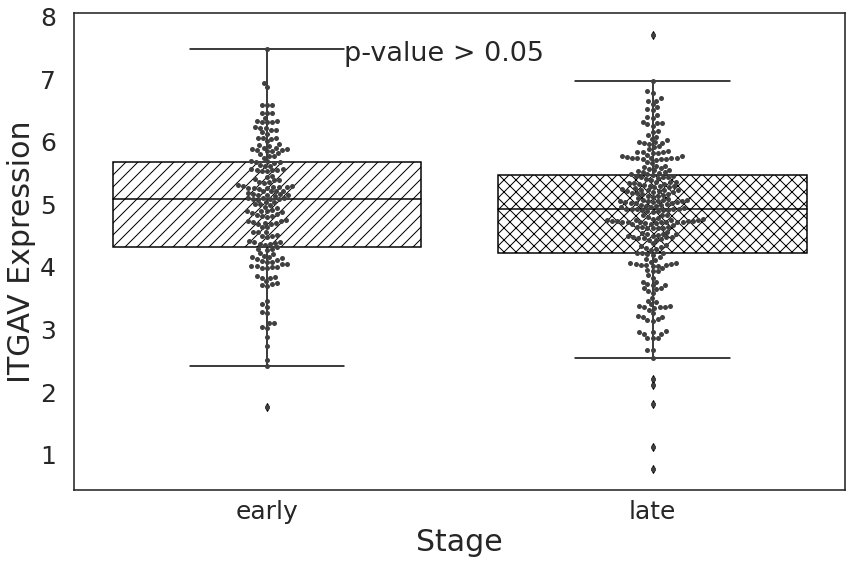

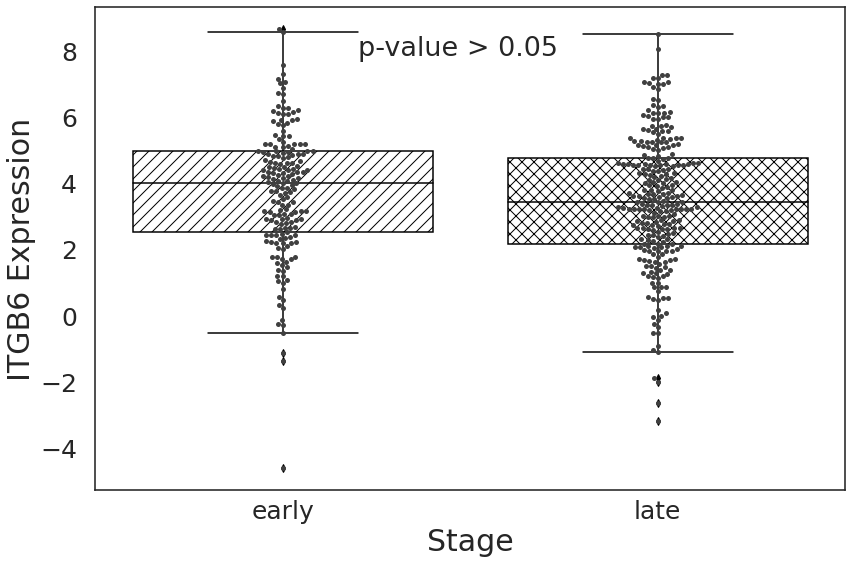

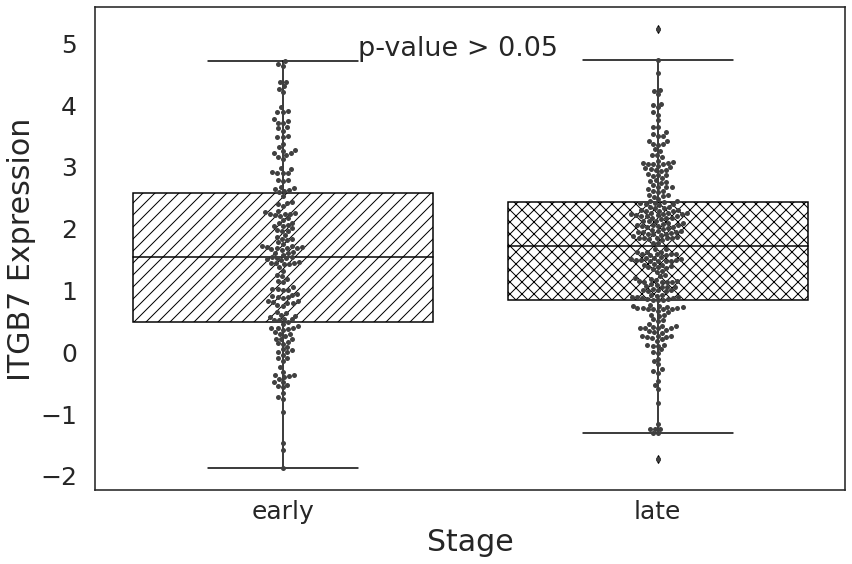

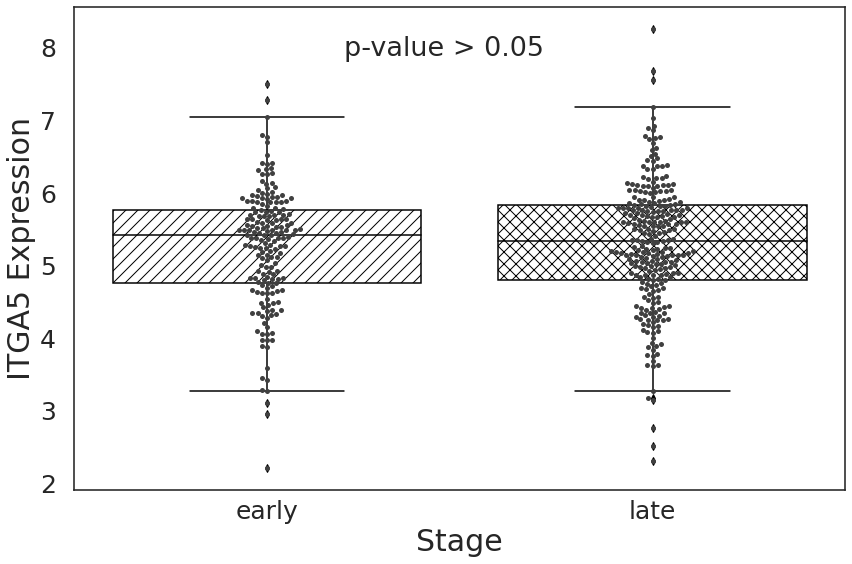

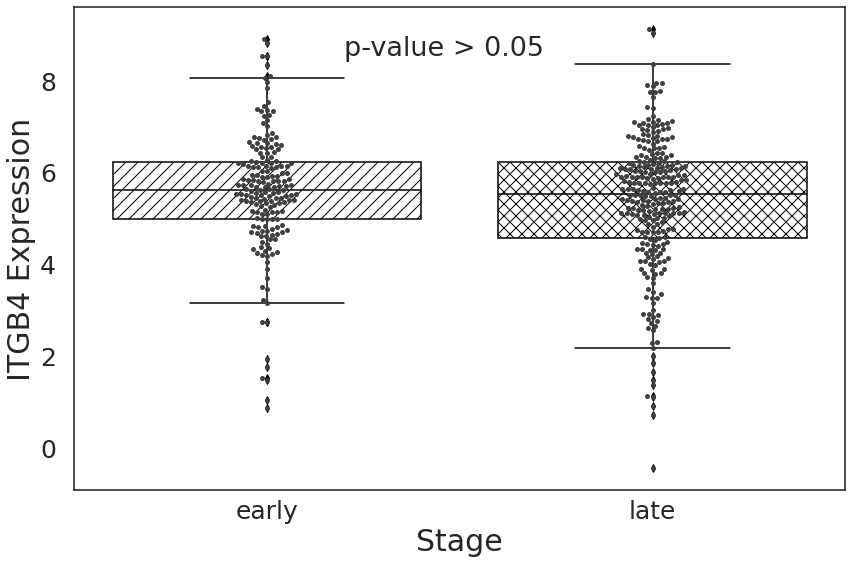

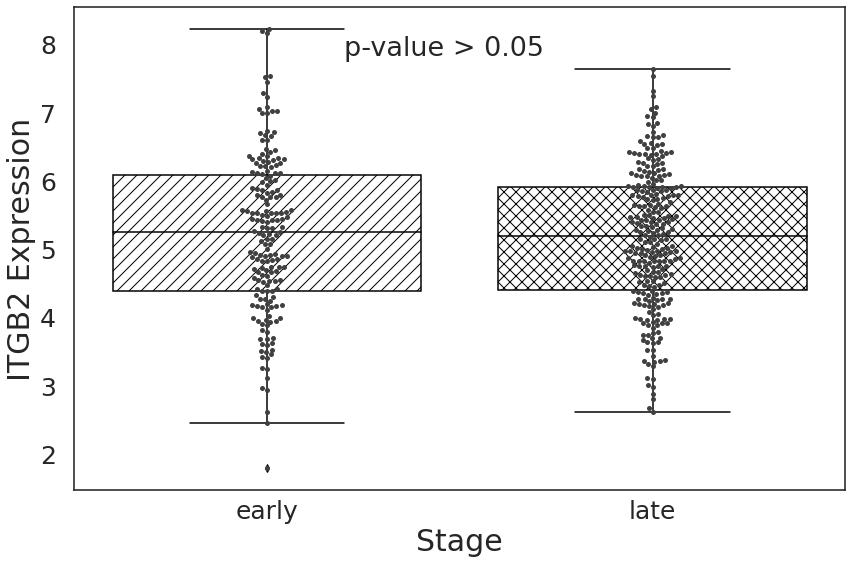

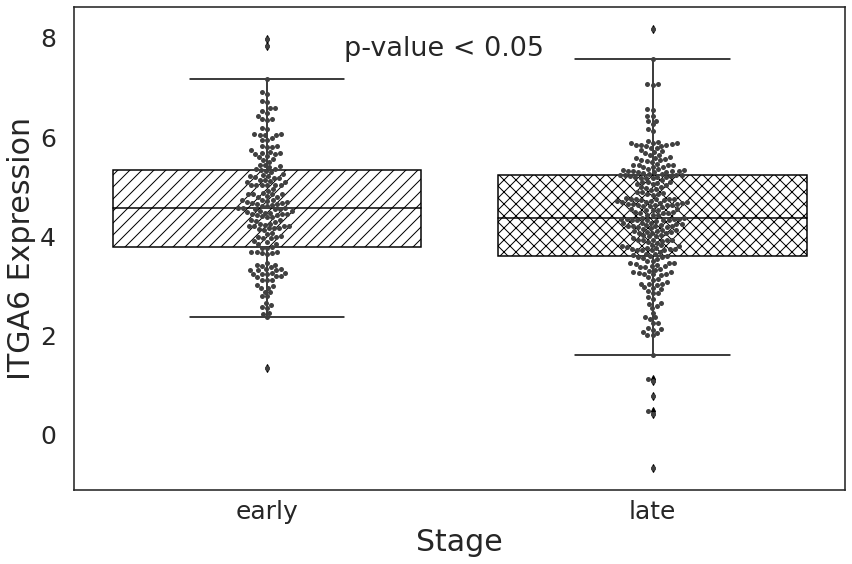

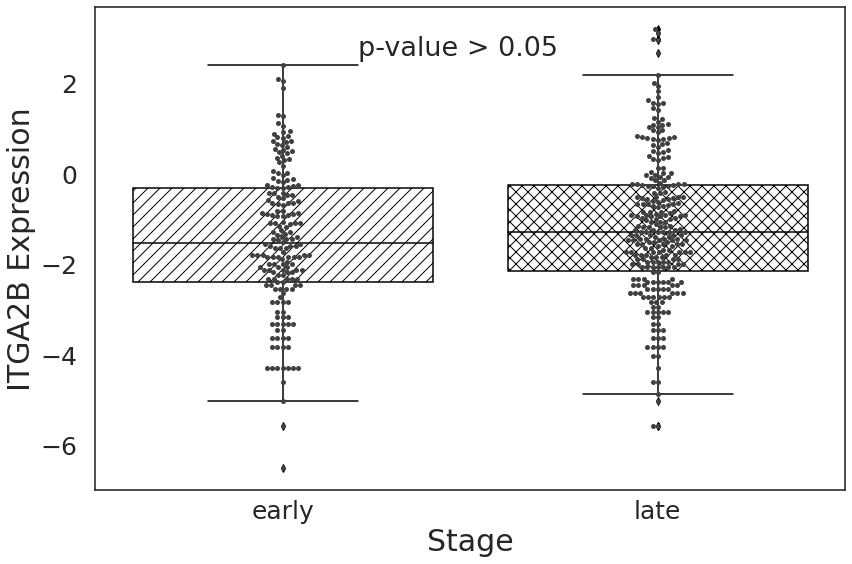

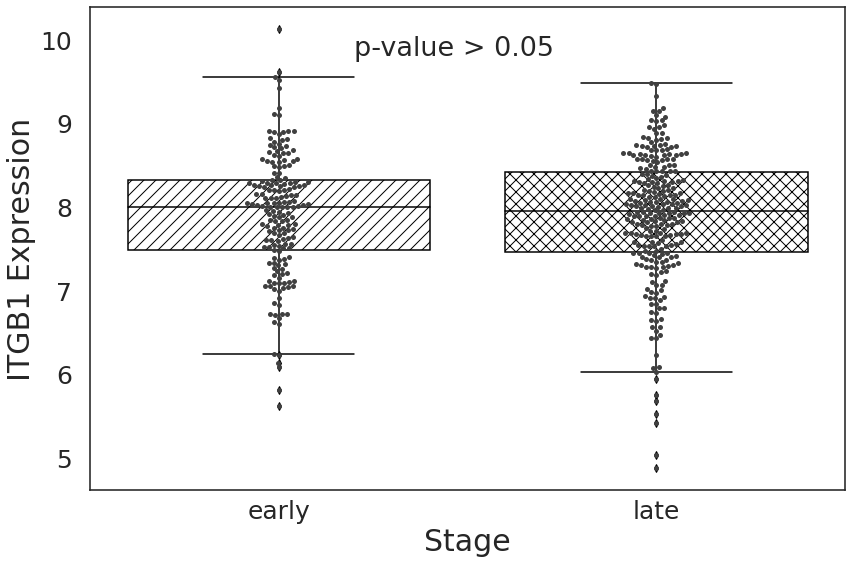

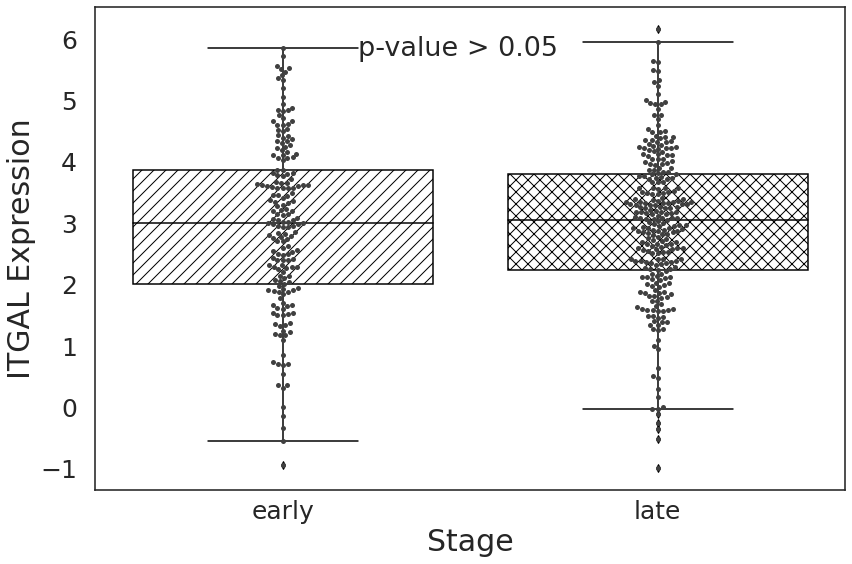

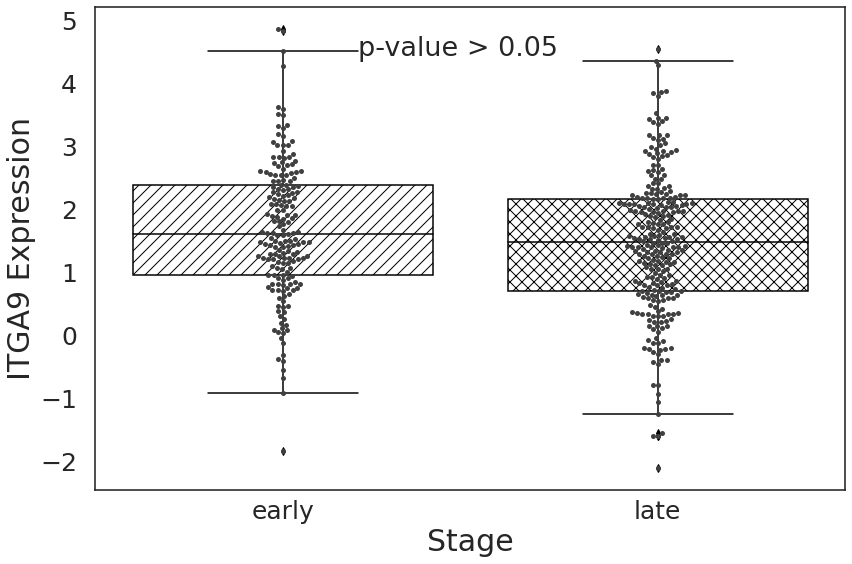

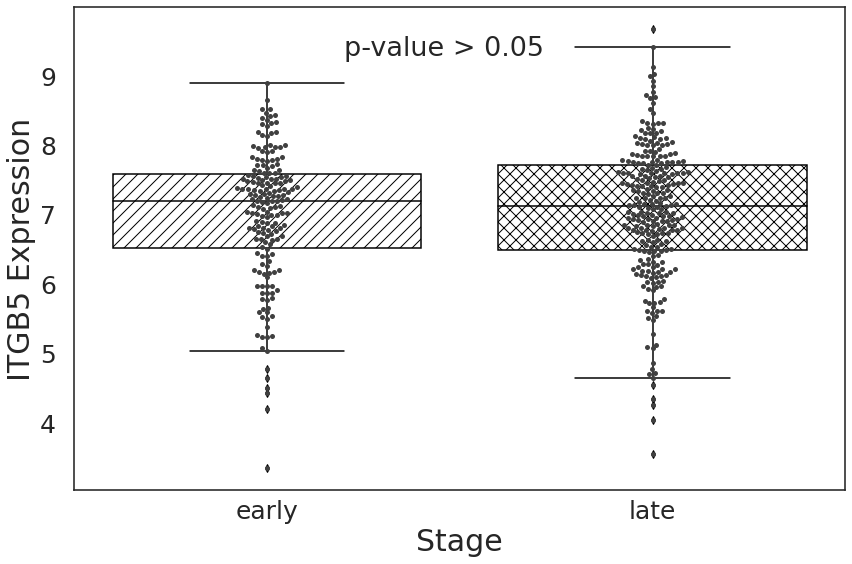

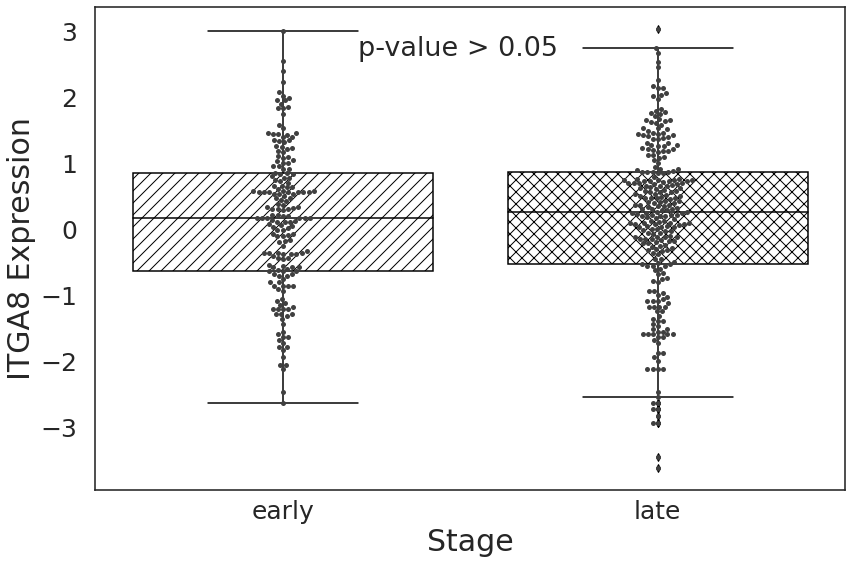

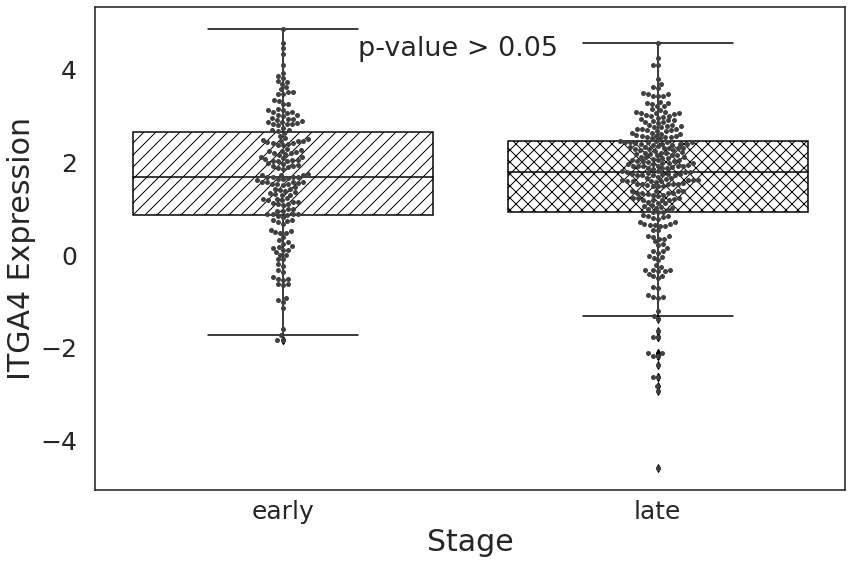

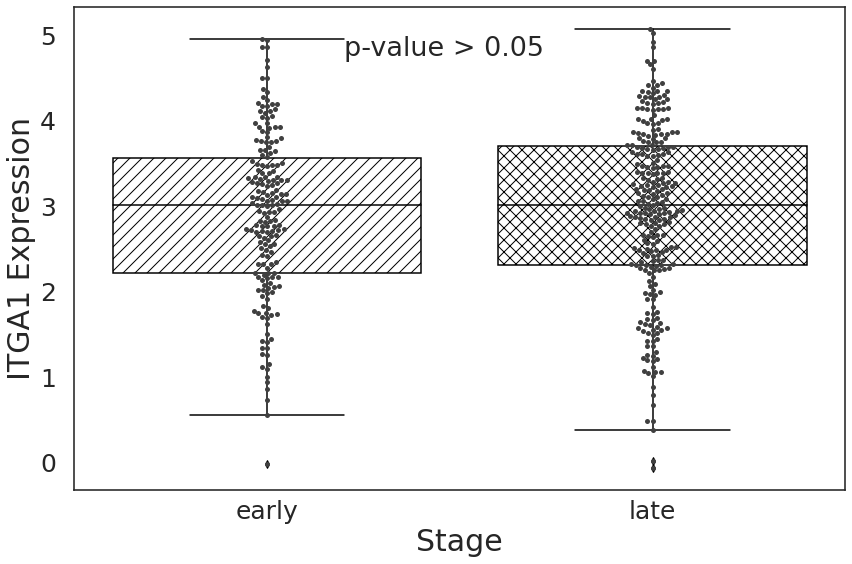

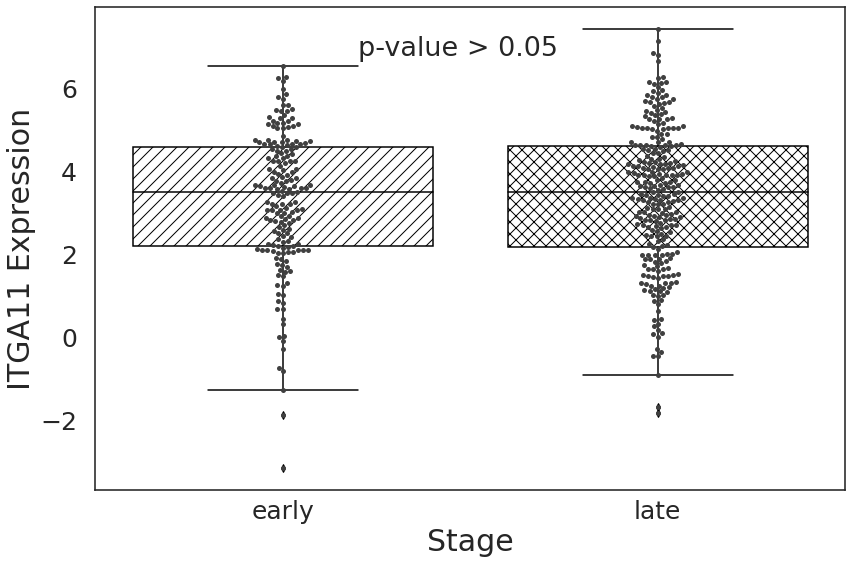

In [126]:
for chosen_integrin in early_stage_ITG.columns:
    test_itg_early = pd.DataFrame(early_stage_ITG[chosen_integrin])
    test_itg_early['integrin'] = np.repeat(test_itg_early.columns[0],test_itg_early.shape[0])
    test_itg_early['stage'] = np.repeat('early',test_itg_early.shape[0])
    test_itg_late = pd.DataFrame(late_stage_ITG[chosen_integrin])
    test_itg_late['integrin'] = np.repeat(test_itg_late.columns[0],test_itg_late.shape[0])
    test_itg_late['stage'] = np.repeat('late',test_itg_late.shape[0])
    test_itg = pd.concat([test_itg_early,test_itg_late]).copy()

    fig,axes=plt.subplots(figsize=(12,8))

    df = test_itg.copy()

    j=0
    sns.set(style="white")
    min_lim_expr=df[chosen_integrin].min()
    max_lim_expr=df[chosen_integrin].max()

    ax=sns.boxplot(data=df,
                      x='stage',y=chosen_integrin,ax=axes,color='black',showfliers=False)
    ax=sns.swarmplot(data=df,
                      x='stage',y=chosen_integrin,ax=axes,color='.25')
    # hatches must equal the number of hues (3 in this case)
    hatches = ['//', 'xx']

    # select the correct patches
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # the number of patches should be evenly divisible by the number of hatches
    h = hatches * (len(patches) // len(hatches))
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor('none')

    # l = ax.legend(fontsize=21)

    # for lp, hatch in zip(l.get_patches(), hatches):
    #     lp.set_hatch(hatch)
    #     fc = lp.get_facecolor()
    #     lp.set_edgecolor(fc)
    #     lp.set_facecolor('none')        

    #ax.set_xticklabels([i.split(' ')[0] for i in interesting_cancers],fontsize=25)
    plt.setp(ax.get_xticklabels(),fontsize=25)
    ax.tick_params(axis='y', labelsize=25)      
    axes.set_xlabel('Stage',fontsize=30)
    axes.set_ylabel(chosen_integrin+' Expression',fontsize=30)

    a = test_itg[test_itg.stage=='early'][chosen_integrin].values
    b = test_itg[test_itg.stage=='late'][chosen_integrin].values
    ttest = stats.ttest_ind(a, b)

    if ttest.pvalue<0.05:
        ax.text(0.35,
                   0.9,f'p-value < 0.05',
                   transform=ax.transAxes,fontsize=27)
    elif ttest.pvalue>0.05:
        ax.text(0.35,
                   0.9,f'p-value > 0.05',
                   transform=ax.transAxes,fontsize=27)
    elif ttest.pvalue==0.05:
        ax.text(0.3,
                   0.8,f'p-value = 0.05',
                   transform=ax.transAxes,fontsize=27)

    del a,b

    #axes.set_ylim(min_lim_expr,max_lim_expr)
    #axes.set_ylim(-4.5,10)
    #axes.set_title(f'GTEx Breast vs TCGA Pan Cancer Dataset: {interesting_integrin}',fontsize=30)

    for i in ['top', 'left', 'right', 'bottom']:
        axes.spines[i].set_linewidth(1.6)

    axes.minorticks_on()
    axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
    axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   



    j+=1

    plt.tight_layout()
    del chosen_integrin, test_itg_early, test_itg_late, test_itg

    #plt.savefig(f'figures/TCGA_BRCA_network{interesting_integrin}_expr.png', dpi = 1000, bbox_inches='tight')


ITGA10 0.02531661735926739
ITGB3 0.019308256885028664
ITGB8 0.0036282434104013576
ITGA6 0.020581672445431128


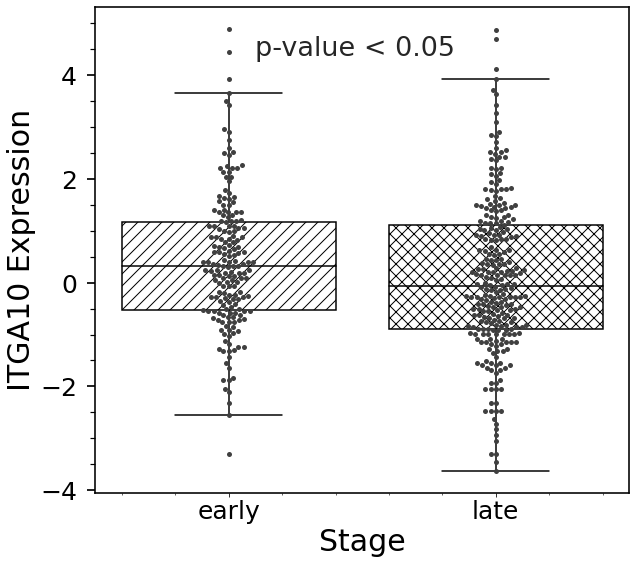

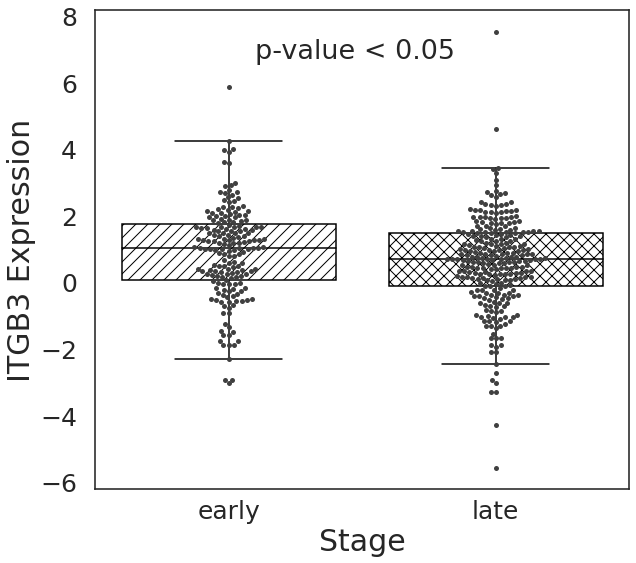

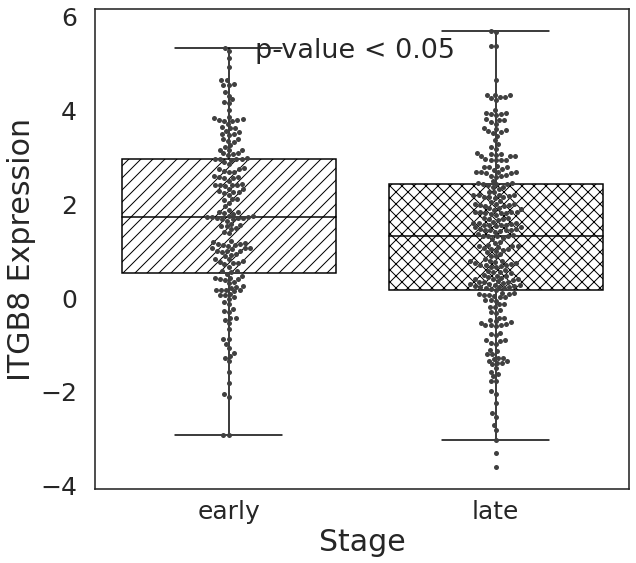

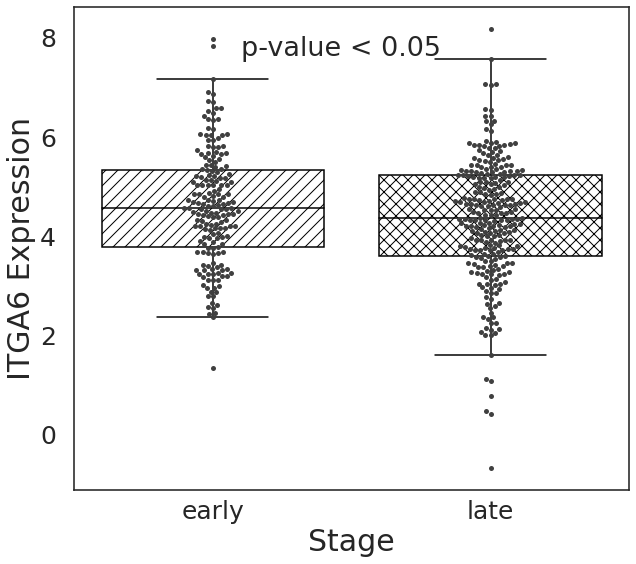

In [19]:
only_itg = []


for chosen_integrin in early_stage_ITG.columns:
    test_itg_early = pd.DataFrame(early_stage_ITG[chosen_integrin])
    test_itg_early['integrin'] = np.repeat(test_itg_early.columns[0],test_itg_early.shape[0])
    test_itg_early['stage'] = np.repeat('early',test_itg_early.shape[0])
    test_itg_late = pd.DataFrame(late_stage_ITG[chosen_integrin])
    test_itg_late['integrin'] = np.repeat(test_itg_late.columns[0],test_itg_late.shape[0])
    test_itg_late['stage'] = np.repeat('late',test_itg_late.shape[0])
    test_itg = pd.concat([test_itg_early,test_itg_late]).copy()
    a = test_itg[test_itg.stage=='early'][chosen_integrin].values
    b = test_itg[test_itg.stage=='late'][chosen_integrin].values
    ttest = stats.ttest_ind(a, b)
    if ttest.pvalue<0.05:
        fig,axes=plt.subplots(figsize=(9,8))
        print(chosen_integrin, ttest.pvalue)
        df = test_itg.copy()

        j=0
        sns.set(style="white")
        min_lim_expr=df[chosen_integrin].min()
        max_lim_expr=df[chosen_integrin].max()

        ax=sns.boxplot(data=df,
                          x='stage',y=chosen_integrin,ax=axes,color='black',showfliers=False)
        ax=sns.swarmplot(data=df,
                          x='stage',y=chosen_integrin,ax=axes,color='.25')
        # hatches must equal the number of hues (3 in this case)
        hatches = ['//', 'xx']

        # select the correct patches
        patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

        # l = ax.legend(fontsize=21)

        # for lp, hatch in zip(l.get_patches(), hatches):
        #     lp.set_hatch(hatch)
        #     fc = lp.get_facecolor()
        #     lp.set_edgecolor(fc)
        #     lp.set_facecolor('none')        

        #ax.set_xticklabels([i.split(' ')[0] for i in interesting_cancers],fontsize=25)
        plt.setp(ax.get_xticklabels(),fontsize=25)
        ax.tick_params(axis='y', labelsize=25)      
        axes.set_xlabel('Stage',fontsize=30)
        axes.set_ylabel(chosen_integrin+' Expression',fontsize=30)

        a = test_itg[test_itg.stage=='early'][chosen_integrin].values
        b = test_itg[test_itg.stage=='late'][chosen_integrin].values
        ttest = stats.ttest_ind(a, b)

        if ttest.pvalue<0.05:
            ax.text(0.3,
                       0.9,f'p-value < 0.05',
                       transform=ax.transAxes,fontsize=27)
        elif ttest.pvalue>0.05:
            ax.text(0.3,
                       0.9,f'p-value > 0.05',
                       transform=ax.transAxes,fontsize=27)
        elif ttest.pvalue==0.05:
            ax.text(0.3,
                       0.8,f'p-value = 0.05',
                       transform=ax.transAxes,fontsize=27)

        del a,b

        #axes.set_ylim(min_lim_expr,max_lim_expr)
        #axes.set_ylim(-4.5,10)
        #axes.set_title(f'GTEx Breast vs TCGA Pan Cancer Dataset: {interesting_integrin}',fontsize=30)

        for i in ['top', 'left', 'right', 'bottom']:
            axes.spines[i].set_linewidth(1.6)

        axes.minorticks_on()
        axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
        axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   



        j+=1

        plt.tight_layout()
    del chosen_integrin, test_itg_early, test_itg_late, test_itg

    #plt.savefig(f'figures/TCGA_BRCA_network{interesting_integrin}_expr.png', dpi = 1000, bbox_inches='tight')


In [128]:
del early_stage_ITG, late_stage_ITG

# compare integrins with other functionally relevant gene sets

In [26]:
# NOTE: i changed ORC6L to ORC6

PAM50_geneset = ['ACTR3B', 'ANLN', 'BAG1','BCL2', 'BIRC5', 'BLVRA', 'CCNB1', 
                 'CCNE1', 'CDC20', 'CDC6', 'CDH3', 'CENPF', 'CEP55', 'CXXC5', 
                 'EGFR', 'ERBB2', 'ESR1', 'EXO1', 'FGFR4', 'FOXA1', 'FOXC1', 
                 'GPR160', 'GRB7', 'KIF2C', 'KRT14', 'KRT17', 'KRT5', 'MAPT',
                 'MDM2', 'MELK', 'MIA', 'MKI67', 'MLPH', 'MMP11', 'MYBL2', 'MYC',
                 'NAT1', 'NDC80', 'NUF2', 'ORC6', 'PGR', 'PHGDH', 'PTTG1',
                 'RRM2', 'SFRP1', 'SLC39A6', 'TMEM45B', 'TYMS', 'UBE2C', 'UBE2T']


In [27]:
for genepam in PAM50_geneset:
    try:
        print(tcga_brca_df_primtum_all[genepam].shape[0])
    except:
        print('missing gene =', genepam)

1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079


In [28]:
for genepam in PAM50_geneset:
    try:
        print(df_int[genepam].shape[0])
    except:
        print('missing gene =', genepam)

80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80


In [106]:
#set up some identity information

gtex_normal_pam50 = df_int[PAM50_geneset+['ITGA7']].copy()
gtex_normal_pam50['sample_category'] = np.repeat('normal_breast',gtex_normal_pam50.shape[0])

primtum_all_pam50 = tcga_brca_df_primtum_all[PAM50_geneset+['ITGA7']].copy()
primtum_all_pam50['sample_category'] = np.repeat('BRCA_primtum',primtum_all_pam50.shape[0])

combined_pam50 = pd.concat([gtex_normal_pam50,
                            primtum_all_pam50]).copy()
del gtex_normal_pam50, primtum_all_pam50
combined_pam50

gene,ACTR3B,ANLN,BAG1,BCL2,BIRC5,BLVRA,CCNB1,CCNE1,CDC20,CDC6,...,PTTG1,RRM2,SFRP1,SLC39A6,TMEM45B,TYMS,UBE2C,UBE2T,ITGA7,sample_category
GTEX-X4EP-2926-SM-3P5YQ,3.381400,-1.595100,5.974600,3.014500,-0.320100,5.652500,1.795400,-0.575600,-1.026200,-1.994200,...,1.422800,-1.248100,7.226700,5.213800,1.803600,2.050000,-0.968600,-0.394000,5.385100,normal_breast
GTEX-11P81-1926-SM-5BC53,2.971000,1.138200,5.730100,3.587500,1.138200,5.336300,3.361900,-0.215900,1.727300,-0.182800,...,2.573100,1.934000,7.199800,5.753000,0.506900,3.708300,2.299000,1.678500,7.151300,normal_breast
GTEX-13FTY-2226-SM-5J1ND,3.455600,-1.214200,6.265900,4.343500,-0.492100,5.561700,3.005600,-0.249800,0.252200,-0.783400,...,1.395600,-0.886300,7.612000,7.255900,3.605400,2.782600,-0.215900,1.531600,6.031900,normal_breast
GTEX-S32W-2026-SM-4AD6E,2.641800,-2.634900,5.970200,2.425200,-2.727400,5.535500,1.556300,-1.117200,-0.375200,-1.937900,...,1.480800,-3.046900,3.232800,3.595900,-5.573500,1.692000,-0.664300,0.423300,9.022300,normal_breast
GTEX-13O3O-0826-SM-5K7WE,3.226700,-0.641600,6.485600,2.205100,-0.997100,5.628800,1.828200,-1.214200,0.537000,-0.452100,...,2.094600,-0.997100,6.307800,6.502100,1.245500,2.467500,0.824600,0.412500,5.271700,normal_breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,1.928884,2.013500,4.930813,4.730473,1.896955,5.481068,4.211078,-0.249840,2.282256,0.743561,...,3.373981,3.917209,4.023970,9.387770,2.808251,3.561212,2.997148,2.759346,1.341627,BRCA_primtum
TCGA-A7-A13E-01,4.470372,5.007389,5.655017,3.168471,3.284571,4.654643,4.315026,1.431734,4.922382,2.252268,...,4.710248,3.955179,5.695850,6.423132,-0.554279,4.879634,5.797720,4.733749,1.440582,BRCA_primtum
TCGA-A7-A0DB-01,2.372316,2.319334,4.795165,3.336411,1.800848,4.676041,4.476862,0.345974,2.605133,1.135962,...,3.299253,3.462601,2.823970,7.933719,2.068409,3.135436,3.493696,3.098377,2.185096,BRCA_primtum
TCGA-A7-A26J-01,1.957642,2.688022,4.776694,4.318141,3.352974,5.759551,5.052413,0.875286,3.415618,2.631742,...,4.288192,3.875243,3.120659,9.723707,0.503538,4.145794,4.689938,4.156547,1.572534,BRCA_primtum


CPU times: user 1min 25s, sys: 550 ms, total: 1min 26s
Wall time: 1min 27s


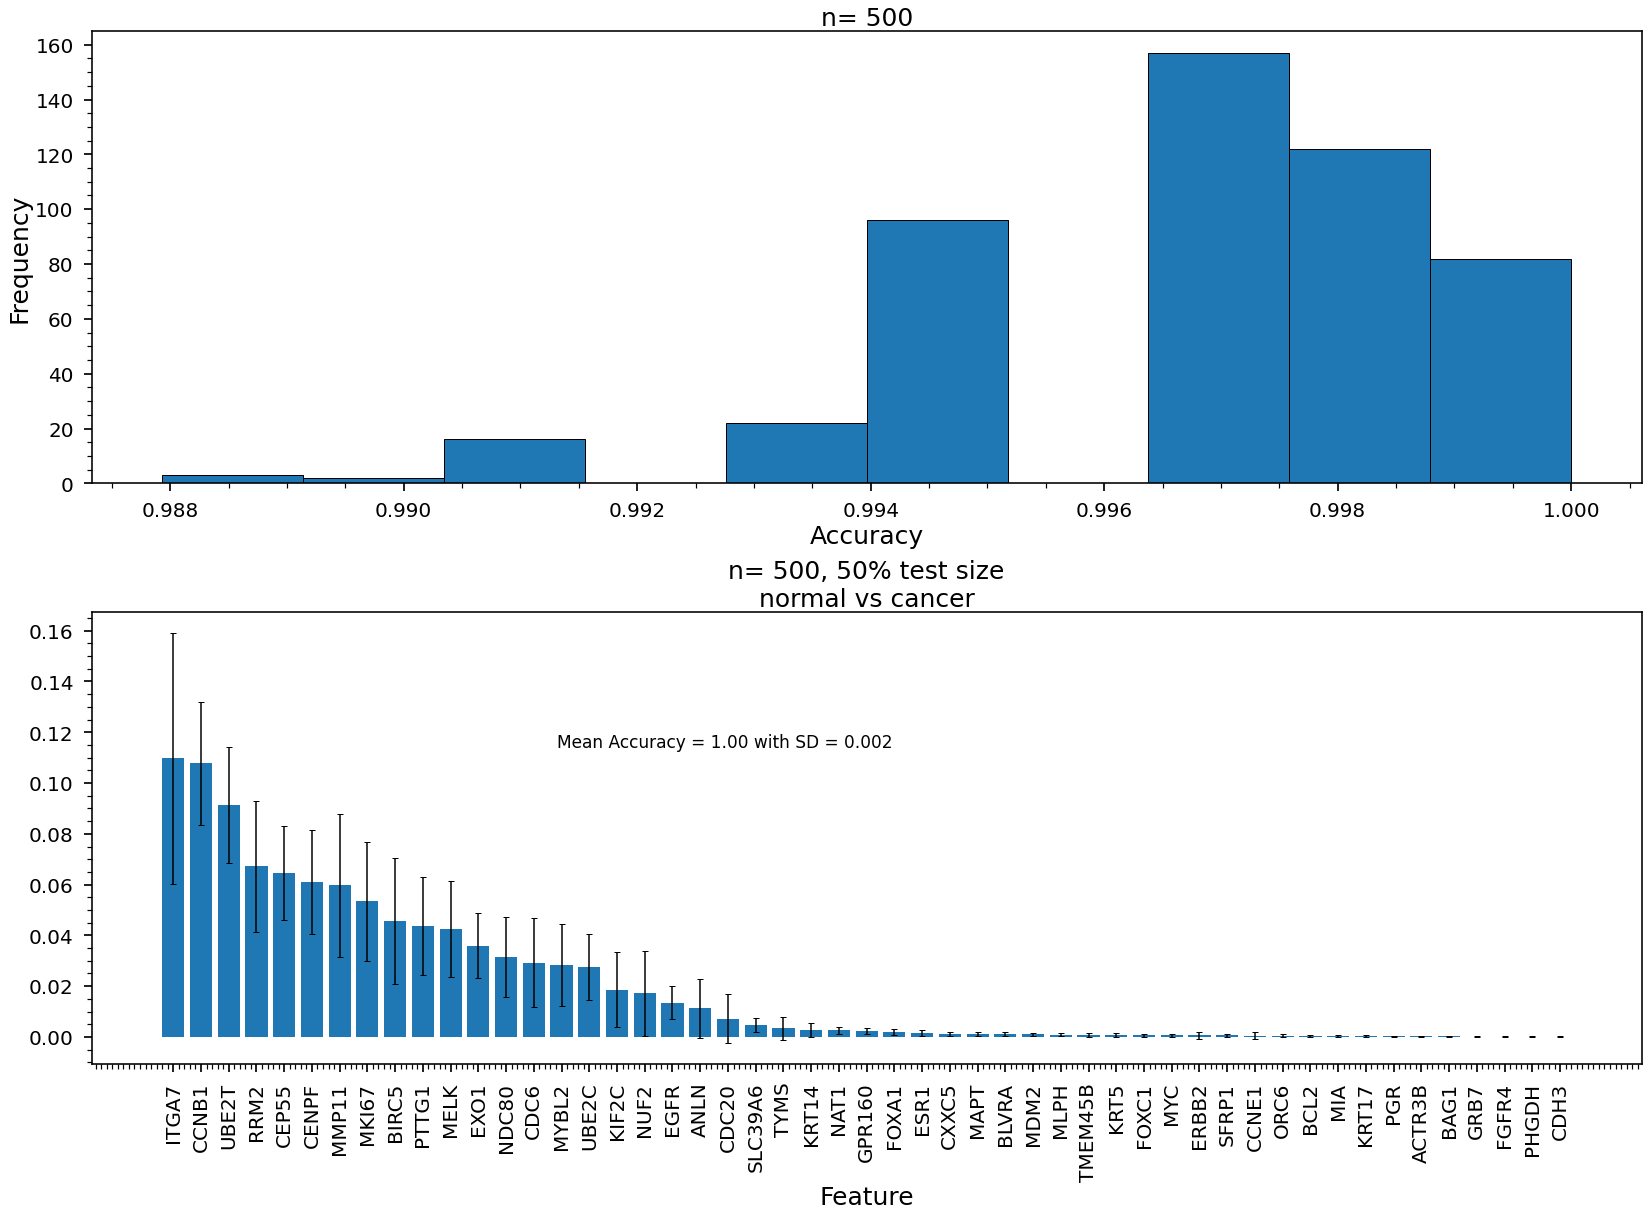

In [126]:
%%time
label_canc='normal vs cancer'
#class weight balanced here
#DO NOT MAKE mistake on title cancer label. be careful 
fig, ax = plt.subplots(2,1, figsize=(23, 17))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score=[]
y_test_total=[]
y_pred_total=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = combined_pam50[combined_pam50.columns[combined_pam50.columns!='sample_category']]
    y = combined_pam50.sample_category
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                        class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    y_test_total=y_test_total+list(y_test)
    y_pred_total=y_pred_total+list(y_pred)
    accuracy.append(accuracy_score(y_test,y_pred))
    #f1score.append(f1_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]


bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3)

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size\n{label_canc}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
# handles = [mpatches.Patch(color=colors[i]) for i in colors]
# labels = [f'{i} expression' for i in colors]
# plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax[1].text(0.3,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)

#ax[0].remove()
plt.tight_layout()

#plt.savefig(f'figures/gtex_tcga_pan_{label_canc}_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')




In [ ]:
#check one integrin at a time

itg_list = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].columns.to_list()

for single_integrin in itg_list:
    gtex_normal_pam50 = df_int[PAM50_geneset+[single_integrin]].copy()
    gtex_normal_pam50['sample_category'] = np.repeat('normal_breast',gtex_normal_pam50.shape[0])

    primtum_all_pam50 = tcga_brca_df_primtum_all[PAM50_geneset+[single_integrin]].copy()
    primtum_all_pam50['sample_category'] = np.repeat('BRCA_primtum',primtum_all_pam50.shape[0])

    combined_pam50_single_integrin = pd.concat([gtex_normal_pam50,
                                primtum_all_pam50]).copy()
    del gtex_normal_pam50, primtum_all_pam50
    label_canc='normal vs cancer'
    #class weight balanced here
    n=500
    feature_importance=[]
    accuracy=[]
    test_size=0.50
    auc_roc=[]
    f1score=[]
    y_test_total=[]
    y_pred_total=[]
    feature_importances={"feature": [],"importance": []}
    for iteration in range(n):
        X = combined_pam50_single_integrin[combined_pam50_single_integrin.columns[combined_pam50_single_integrin.columns!='sample_category']]
        y = combined_pam50_single_integrin.sample_category
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        ### Random Forest Classifier ###
        classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                            class_weight= 'balanced')
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        y_test_total=y_test_total+list(y_test)
        y_pred_total=y_pred_total+list(y_pred)
        accuracy.append(accuracy_score(y_test,y_pred))
        #f1score.append(f1_score(y_test,y_pred))
        #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
        for i,j in zip(X.columns,classifier.feature_importances_):
            feature_importances['feature'].append(i) 
            feature_importances['importance'].append(j)
    #now plotting
    #print(single_integrin, f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}')
    feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
    feature_importance_df = feature_importance_df.sort_values(by='importance')
    feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

    feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
    print(f'The importance rank for {single_integrin} out of {feature_importance_df_mean.shape[0]-1}: ',
          np.nonzero(np.array(feature_importance_df_mean.reset_index().feature==single_integrin))[0][0])

del combined_pam50_single_integrin


The importance rank for ITGA10 out of 50:  20


In [83]:
#remove AC010422.5

donato_ctc_32genesig= ['TMEM125','VPS13D','POLR2J2','CCDC9',
'PGGT1B',
'SNAPC3','VEGFA',
'UBALD1',
'CLCN2','ZNF771',
'FAM13A',
'ABCC5','IKZF2',
'ZBTB43',
'IRS1',
'BIVM',
'PIK3C2B',
'LRIG2',
'MLLT3',
'PLD6',
'P4HA1',
'GDF15',
'LIPT1',
'MACC1',
'PPP1R3E',
'EPHX2',
'POFUT1',
'NIPAL1',
'CCNG2',
'HIF1A',
'CTSS']


In [84]:
for gene32 in donato_ctc_32genesig:
    try:
        print(df_int[gene32].shape[0])
    except:
        print('missing gene =', gene32)

80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80


In [85]:
for gene32 in donato_ctc_32genesig:
    try:
        print(tcga_brca_df_primtum_all[gene32].shape[0])
    except:
        print('missing gene =', gene32)

1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079
1079


In [88]:
#set up some identity information

gtex_normal_donato32 = df_int[donato_ctc_32genesig+['ITGA7']].copy()
gtex_normal_donato32['sample_category'] = np.repeat('normal_breast',gtex_normal_donato32.shape[0])

primtum_all_donato32 = tcga_brca_df_primtum_all[donato_ctc_32genesig+['ITGA7']].copy()
primtum_all_donato32['sample_category'] = np.repeat('BRCA_primtum',primtum_all_donato32.shape[0])

combined_donato32 = pd.concat([gtex_normal_donato32,
                            primtum_all_donato32]).copy()
del gtex_normal_donato32, primtum_all_donato32
combined_donato32

gene,TMEM125,VPS13D,POLR2J2,CCDC9,PGGT1B,SNAPC3,VEGFA,UBALD1,CLCN2,ZNF771,...,MACC1,PPP1R3E,EPHX2,POFUT1,NIPAL1,CCNG2,HIF1A,CTSS,ITGA7,sample_category
GTEX-X4EP-2926-SM-3P5YQ,3.084200,4.756000,0.379600,5.670500,2.840200,3.732400,7.398300,4.852500,1.887900,1.428100,...,2.233000,4.277300,5.000000,3.593500,-0.150400,5.548800,6.126200,5.376100,5.385100,normal_breast
GTEX-11P81-1926-SM-5BC53,3.190800,4.262400,-0.013000,4.076500,2.874000,4.043600,6.090000,4.005500,1.637400,1.339700,...,1.401100,3.957100,4.873900,3.965400,0.015800,5.767200,5.085000,4.937400,7.151300,normal_breast
GTEX-13FTY-2226-SM-5J1ND,5.108100,4.540500,0.614500,5.579900,3.114500,4.157900,7.309800,5.597300,3.160400,2.433200,...,3.106200,4.559600,5.393000,3.789800,0.444700,6.882700,5.397500,4.420300,6.031900,normal_breast
GTEX-S32W-2026-SM-4AD6E,-2.388400,4.201700,-0.302200,4.010900,2.817800,3.664600,5.931000,4.299500,1.609300,2.467500,...,-4.293400,4.085800,3.046300,3.723700,-4.293400,3.714900,5.167200,4.363200,9.022300,normal_breast
GTEX-13O3O-0826-SM-5K7WE,3.473900,3.802300,-1.282800,4.844500,2.630200,3.569400,7.753700,5.004100,0.949300,1.465200,...,1.029300,2.920500,3.089300,3.485600,-0.913200,5.218800,6.039600,4.840000,5.271700,normal_breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,2.778414,3.850083,0.412474,2.779113,4.187802,4.166505,3.836002,2.215475,0.729180,0.190297,...,2.843549,2.434109,4.102775,3.883036,-1.330372,7.055646,5.023880,4.820584,1.341627,BRCA_primtum
TCGA-A7-A13E-01,4.429891,3.295354,1.043328,3.038182,3.293440,4.899398,5.644363,2.636375,0.639356,0.125653,...,4.241667,1.874876,0.819112,4.032493,2.361101,4.754254,5.414523,4.721630,1.440582,BRCA_primtum
TCGA-A7-A0DB-01,2.943803,3.555541,2.161689,3.491110,3.736346,3.625767,3.577855,2.396207,0.543626,0.338344,...,2.280271,2.838823,3.822136,4.676844,-1.026214,5.222793,4.218340,5.795477,2.185096,BRCA_primtum
TCGA-A7-A26J-01,3.108439,4.036907,1.599779,2.914101,4.344429,4.254568,4.557131,2.830721,1.273615,0.794402,...,4.067632,2.317432,2.448297,4.929193,-1.225426,6.453444,5.150869,5.537745,1.572534,BRCA_primtum


In [90]:
#set up some identity information

gtex_normal_donato32 = df_int[donato_ctc_32genesig+['ITGA7']].copy()
gtex_normal_donato32['sample_category'] = np.repeat('normal_breast',gtex_normal_donato32.shape[0])

primtum_all_donato32_early = tcga_brca_df_primtum_early_stage[donato_ctc_32genesig+['ITGA7']].copy()
primtum_all_donato32_early['sample_category'] = np.repeat('BRCA_primtum_early',primtum_all_donato32_early.shape[0])

primtum_all_donato32_late = tcga_brca_df_primtum_late_stage[donato_ctc_32genesig+['ITGA7']].copy()
primtum_all_donato32_late['sample_category'] = np.repeat('BRCA_primtum_late',primtum_all_donato32_late.shape[0])

combined_donato32_earlate = pd.concat([gtex_normal_donato32,
                            primtum_all_donato32_early,
                              primtum_all_donato32_late]).copy()
del gtex_normal_donato32, primtum_all_donato32_early, primtum_all_donato32_late
combined_donato32_earlate

gene,TMEM125,VPS13D,POLR2J2,CCDC9,PGGT1B,SNAPC3,VEGFA,UBALD1,CLCN2,ZNF771,...,MACC1,PPP1R3E,EPHX2,POFUT1,NIPAL1,CCNG2,HIF1A,CTSS,ITGA7,sample_category
GTEX-X4EP-2926-SM-3P5YQ,3.084200,4.756000,0.379600,5.670500,2.840200,3.732400,7.398300,4.852500,1.88790,1.428100,...,2.233000,4.277300,5.000000,3.593500,-0.150400,5.548800,6.12620,5.376100,5.385100,normal_breast
GTEX-11P81-1926-SM-5BC53,3.190800,4.262400,-0.013000,4.076500,2.874000,4.043600,6.090000,4.005500,1.63740,1.339700,...,1.401100,3.957100,4.873900,3.965400,0.015800,5.767200,5.08500,4.937400,7.151300,normal_breast
GTEX-13FTY-2226-SM-5J1ND,5.108100,4.540500,0.614500,5.579900,3.114500,4.157900,7.309800,5.597300,3.16040,2.433200,...,3.106200,4.559600,5.393000,3.789800,0.444700,6.882700,5.39750,4.420300,6.031900,normal_breast
GTEX-S32W-2026-SM-4AD6E,-2.388400,4.201700,-0.302200,4.010900,2.817800,3.664600,5.931000,4.299500,1.60930,2.467500,...,-4.293400,4.085800,3.046300,3.723700,-4.293400,3.714900,5.16720,4.363200,9.022300,normal_breast
GTEX-13O3O-0826-SM-5K7WE,3.473900,3.802300,-1.282800,4.844500,2.630200,3.569400,7.753700,5.004100,0.94930,1.465200,...,1.029300,2.920500,3.089300,3.485600,-0.913200,5.218800,6.03960,4.840000,5.271700,normal_breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A1HO-01,4.521100,4.284700,-0.533200,3.913700,3.985600,4.182800,5.767900,4.230400,2.47270,2.147600,...,-1.392100,2.032500,2.409000,4.574800,-1.148800,5.738800,5.32920,5.304900,1.091500,BRCA_primtum_late
TCGA-PL-A8LZ-01,4.688200,3.281100,-0.734600,5.359700,3.346400,5.033900,5.391000,4.526800,2.97100,2.104700,...,1.614000,1.744600,3.417000,4.384100,1.406500,3.925100,6.41330,8.658800,3.673700,BRCA_primtum_late
TCGA-S3-A6ZH-01,4.051500,3.591100,-0.619300,5.538900,4.534200,4.547300,5.789800,5.238100,1.52160,2.427900,...,1.674000,2.475300,2.727000,4.831400,-0.940600,6.380600,3.87880,6.890600,1.709700,BRCA_primtum_late
TCGA-AR-A0TQ-01,4.545400,3.900200,0.264200,5.264200,4.370200,3.395200,5.085800,4.176400,1.77440,1.575800,...,1.105000,3.264700,2.198800,4.441700,0.276200,5.777400,6.11110,6.451600,1.884000,BRCA_primtum_late


CPU times: user 1min 24s, sys: 618 ms, total: 1min 24s
Wall time: 1min 25s


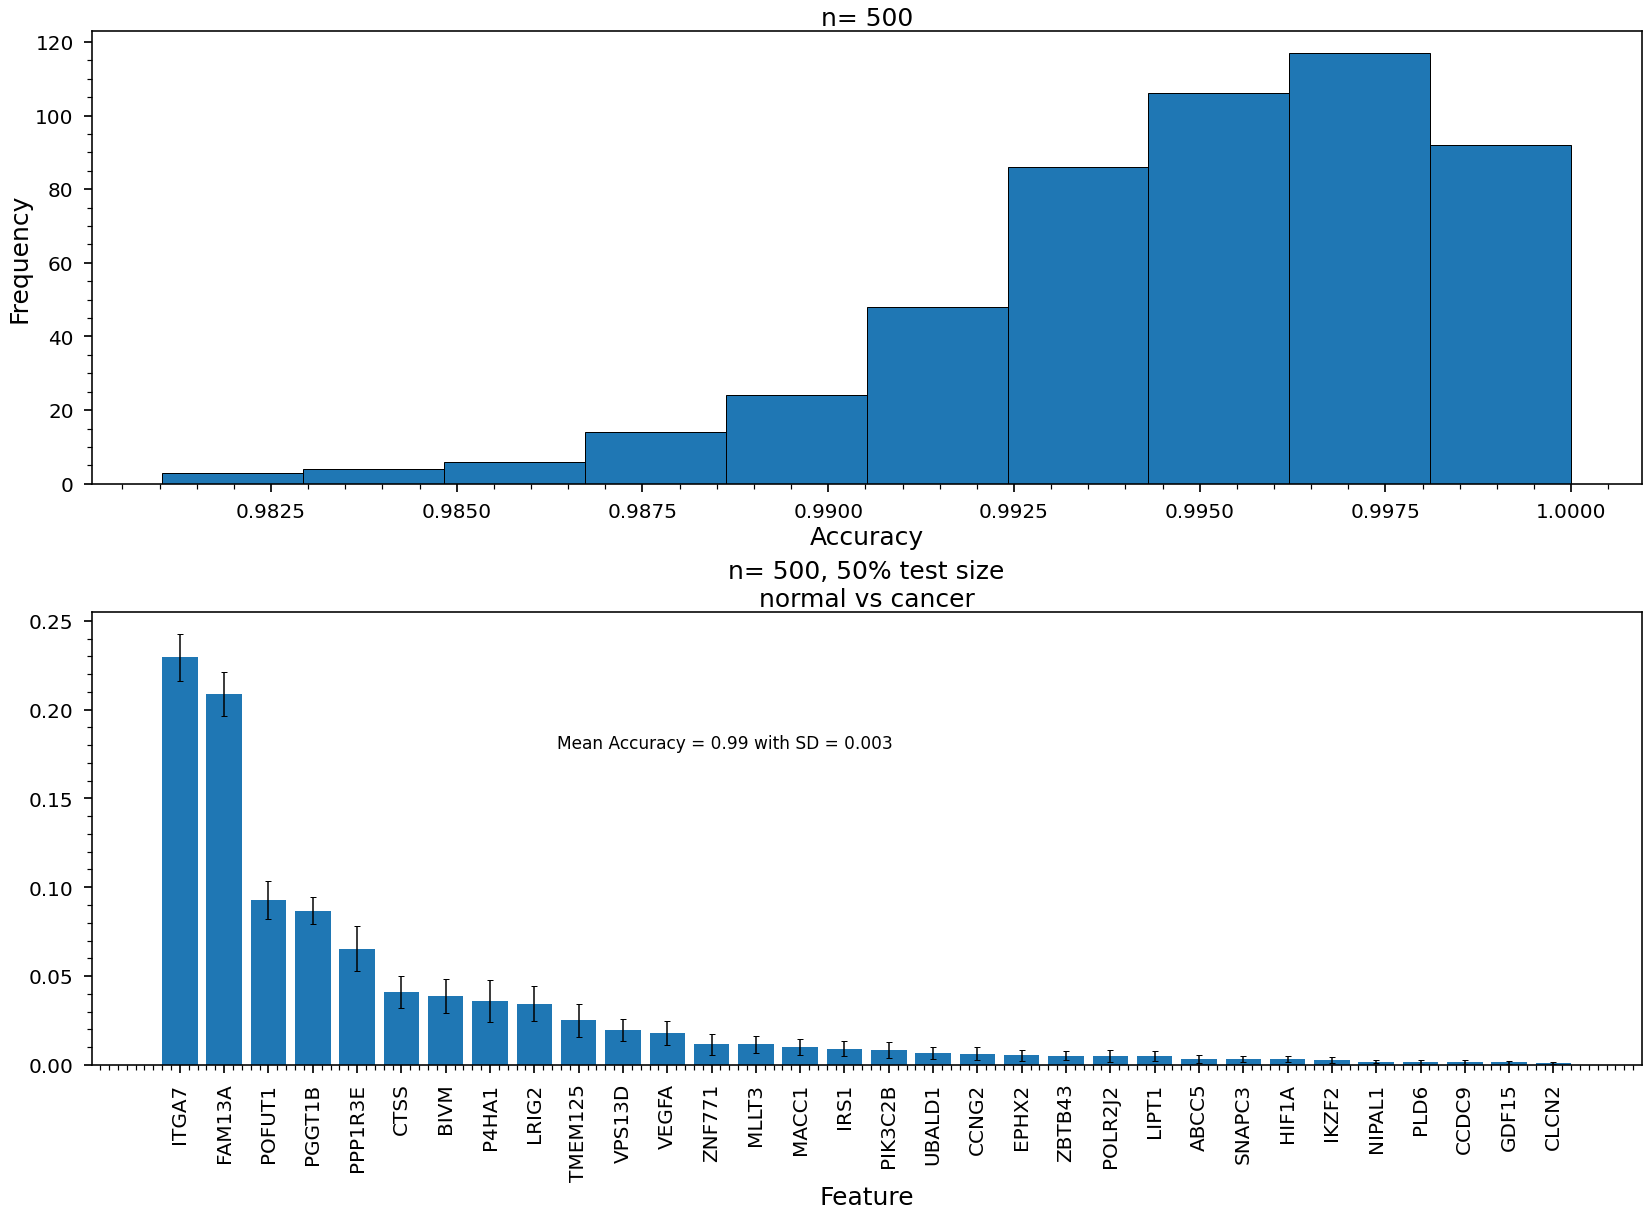

In [89]:
%%time
label_canc='normal vs cancer'
#class weight balanced here
#DO NOT MAKE mistake on title cancer label. be careful 
fig, ax = plt.subplots(2,1, figsize=(23, 17))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score=[]
y_test_total=[]
y_pred_total=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = combined_donato32[combined_donato32.columns[combined_donato32.columns!='sample_category']]
    y = combined_donato32.sample_category
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                        class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    y_test_total=y_test_total+list(y_test)
    y_pred_total=y_pred_total+list(y_pred)
    accuracy.append(accuracy_score(y_test,y_pred))
    #f1score.append(f1_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]


bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3)

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size\n{label_canc}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
# handles = [mpatches.Patch(color=colors[i]) for i in colors]
# labels = [f'{i} expression' for i in colors]
# plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax[1].text(0.3,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)

#ax[0].remove()
plt.tight_layout()

#plt.savefig(f'figures/gtex_tcga_pan_{label_canc}_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')




In [ ]:
#check one integrin at a time

itg_list = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].columns.to_list()

for single_integrin in itg_list:
    gtex_normal_donato32 = df_int[donato_ctc_32genesig+[single_integrin]].copy()
    gtex_normal_donato32['sample_category'] = np.repeat('normal_breast',gtex_normal_donato32.shape[0])

    primtum_all_donato32 = tcga_brca_df_primtum_all[donato_ctc_32genesig+[single_integrin]].copy()
    primtum_all_donato32['sample_category'] = np.repeat('BRCA_primtum',primtum_all_donato32.shape[0])

    combined_donato32_single_integrin = pd.concat([gtex_normal_donato32,
                                primtum_all_donato32]).copy()
    del gtex_normal_donato32, primtum_all_donato32    
    label_canc='normal vs cancer'
    #class weight balanced here
    n=500
    feature_importance=[]
    accuracy=[]
    test_size=0.50
    auc_roc=[]
    f1score=[]
    y_test_total=[]
    y_pred_total=[]
    feature_importances={"feature": [],"importance": []}
    for iteration in range(n):
        X = combined_donato32_single_integrin[combined_donato32_single_integrin.columns[combined_donato32_single_integrin.columns!='sample_category']]
        y = combined_donato32_single_integrin.sample_category
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        ### Random Forest Classifier ###
        classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                            class_weight= 'balanced')
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        y_test_total=y_test_total+list(y_test)
        y_pred_total=y_pred_total+list(y_pred)
        accuracy.append(accuracy_score(y_test,y_pred))
        #f1score.append(f1_score(y_test,y_pred))
        #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
        for i,j in zip(X.columns,classifier.feature_importances_):
            feature_importances['feature'].append(i) 
            feature_importances['importance'].append(j)
    #now plotting
    #print(single_integrin, f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}')
    feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
    feature_importance_df = feature_importance_df.sort_values(by='importance')
    feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

    feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
    print(f'The importance rank for {single_integrin} out of {feature_importance_df_mean.shape[0]-1}: ',
          np.nonzero(np.array(feature_importance_df_mean.reset_index().feature==single_integrin))[0][0])

del combined_donato32_single_integrin


CPU times: user 1min 25s, sys: 515 ms, total: 1min 25s
Wall time: 1min 26s


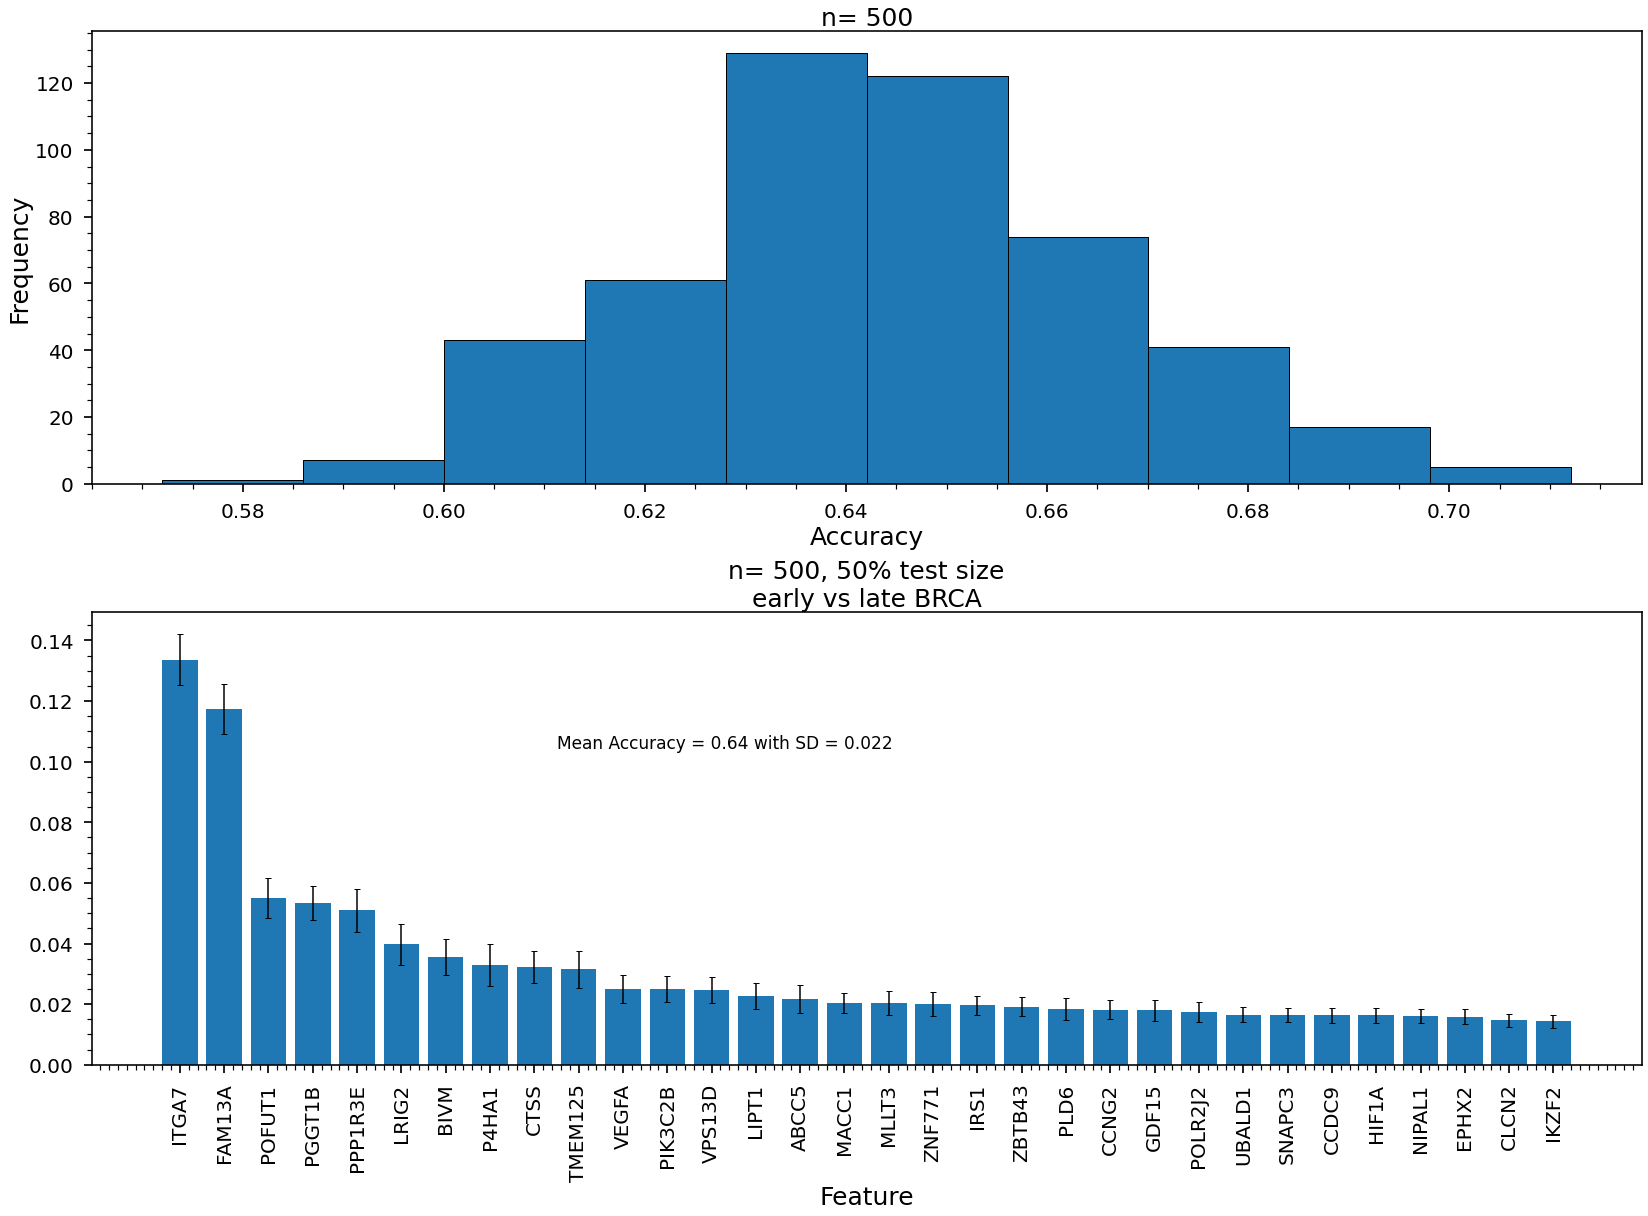

In [91]:
%%time
label_canc='early vs late BRCA'
#class weight balanced here
#DO NOT MAKE mistake on title cancer label. be careful 
fig, ax = plt.subplots(2,1, figsize=(23, 17))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score=[]
y_test_total=[]
y_pred_total=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = combined_donato32_earlate[combined_donato32_earlate.columns[combined_donato32_earlate.columns!='sample_category']]
    y = combined_donato32_earlate.sample_category
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                        class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    y_test_total=y_test_total+list(y_test)
    y_pred_total=y_pred_total+list(y_pred)
    accuracy.append(accuracy_score(y_test,y_pred))
    #f1score.append(f1_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]


bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3)

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size\n{label_canc}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
# handles = [mpatches.Patch(color=colors[i]) for i in colors]
# labels = [f'{i} expression' for i in colors]
# plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax[1].text(0.3,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)

#ax[0].remove()
plt.tight_layout()

#plt.savefig(f'figures/gtex_tcga_pan_{label_canc}_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')




# star protocols paper

# link to star protocols paper: https://star-protocols.cell.com/protocols/1689

In [ ]:

#import pingouin as pg
import gseapy as gp

In [18]:
#gtex_network_df=pd.read_csv('gtex_network_df_star_protocols_mcdonald2022.csv')
#tcga_primtum_all_network_df=pd.read_csv('tcga_primtum_all_network_df_star_protocols_mcdonald2022.csv')
correlation_cutoff


0.6

In [19]:
#first getting pairwise correlation coefficient
gtex_itg_corr_network=pd.DataFrame(np.corrcoef(df_int,rowvar=False),
                                      columns=df_int.columns,index=df_int.columns)
#filtering out integrins
gtex_itg_corr_network=gtex_itg_corr_network[gtex_itg_corr_network.columns[gtex_itg_corr_network.columns.str.contains('ITG')]]
#only those with >=correlation_cutoff coefficient
gtex_itg_corr_network=gtex_itg_corr_network[gtex_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
#more than self_correlation
gtex_corr_itg_list=gtex_itg_corr_network.count()[gtex_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in gtex_corr_itg_list:
    corr_list[integrin]=gtex_itg_corr_network[integrin].dropna(axis=0).index
    
#just some not-useful code here, previously used to subset those with pval<0.05
#now doing pval<0.05 AND pval>=0.05, basically not caring about pval
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(df_int[integrin].values,df_int[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
gtex_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        gtex_network['node1'].append(integrin)
        gtex_network['node2'].append(gene)
        gtex_network['correlation_strength'].append(pearsonr(df_int[integrin].values,df_int[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])
del running_gene_integrin_list

#establish new df
gtex_network_df=pd.DataFrame(gtex_network)
#remove self-correlation such as ITGAD correlation coefficient with itself
#also reset index with the removed df
gtex_network_df=gtex_network_df.loc[[x for x in gtex_network_df.index if gtex_network_df.loc[x].node1!=gtex_network_df.loc[x].node2]].reset_index(drop=True)
del gtex_network, gtex_itg_corr_network


/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [24]:
gtex_network_df


,node1,node2,correlation_strength
0,ITGA10,EVPL,0.655946
1,ITGA10,DDR1,0.607552
2,ITGA10,ZNF425,0.619213
3,ITGA10,ULK1,0.673472
4,ITGA10,PIGO,0.619894
...,...,...,...
24515,ITGA11,SLC45A3,0.671851
24516,ITGA11,IQCB1,0.612497
24517,ITGA11,TIGD1,0.610385
24518,ITGA11,PRNP,0.604967


In [24]:
# find connected to at least 3 integrins
genes_at_least3 = gtex_network_df['node2'].value_counts()[gtex_network_df['node2'].value_counts()>=3].index
print(genes_at_least3[~(genes_at_least3.str.contains('ITG'))])
del genes_at_least3

Index(['GGA2', 'L3MBTL1', 'NICN1', 'CFAP44', 'KDM2B', 'CEP44', 'CBFA2T2',
       'RNF44', 'WDR59', 'AMT',
       ...
       'PCYT1B', 'ACOT9', 'ACTR2', 'RCCD1', 'ZNF488', 'TMC8', 'ERVMER34-1',
       'ZNF768', 'B3GALNT1', 'CD109'],
      dtype='object', length=3916)


In [25]:
arbitrary_genes=[]
for gene in gtex_network_df['node2'].value_counts()[gtex_network_df['node2'].value_counts()>=5].index:
    if gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean()>=0.80:
        print(gene, gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean())
        arbitrary_genes.append([gene, gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean()])

IRF6 0.8002747655915552
FAM189A2 0.8149883076848556
ANO1 0.8073432269618689
CDS1 0.812728409982613
INADL 0.8096556264295742
WNK2 0.8004944607485559
EPS8L2 0.8094669003206564
SH2D3A 0.8196614054393985
CA13 0.802778570892634
MPZL3 0.8203167401137943
SH3YL1 0.8035680226283431
DTNB 0.8058661028616894
DSP 0.8102610180119125
GRB7 0.8012787670386041
SPINT1 0.8044176250171527
CDH1 0.8121430681882822
TFAP2A 0.8080326774049376
SOX9 0.8116538429263811
SCNN1A 0.8052144820573661
CELF5 0.8003862634775525
MAPK15 0.836748314312487
PROM1 0.8136460757675309
WFDC2 0.8048204337629585
GRHL2 0.8080326120862672
AK5 0.8180776084059641
TMPRSS3 0.8221903843419233
PVRL4 0.8245791526525542
HOMER2 0.8009259275372307
GSTO2 0.8275378560524873
SOSTDC1 0.8078715161496663
CDH3 0.8312850571876824
HOOK1 0.8242895302106907
KRT80 0.8160583856638963
CLDN4 0.8223270888977996
LAD1 0.8062231913862391
KRT18 0.8146616689589544
BSPRY 0.819772628991091
PLCH2 0.8255589396019533
TACSTD2 0.8215799870071875
TRIM29 0.8128196826756019
R

In [26]:
len(arbitrary_genes)

65

In [29]:
for i in arbitrary_genes:
    print(i[0])

IRF6
FAM189A2
ANO1
CDS1
INADL
WNK2
EPS8L2
SH2D3A
CA13
MPZL3
SH3YL1
DTNB
DSP
GRB7
SPINT1
CDH1
TFAP2A
SOX9
SCNN1A
CELF5
MAPK15
PROM1
WFDC2
GRHL2
AK5
TMPRSS3
PVRL4
HOMER2
GSTO2
SOSTDC1
CDH3
HOOK1
KRT80
CLDN4
LAD1
KRT18
BSPRY
PLCH2
TACSTD2
TRIM29
RASAL1
BEX2
SOX10
CADM4
F2RL1
COL17A1
TFAP2C
CD24
ST6GALNAC5
PROM2
PRSS8
FAM110A
SPINT2
D4S234E
TMPRSS2
SLC35F3
C1orf116
KRT8
LRRC4C
SFN
ESRP1
GPRIN2
CCDC64B
SERPINB5
STAP2


In [27]:
gtex_network_df[gtex_network_df.node2.isin(np.array(arbitrary_genes)[:,0])].node1.value_counts()


ITGA2     65
ITGB4     65
ITGB6     65
ITGB8     65
ITGA3     60
ITGA10     9
ITGA4      8
ITGA11     6
Name: node1, dtype: int64

In [ ]:
gtex_network_df[(gtex_network_df.node2.isin(np.array(arbitrary_genes)[:,0])) & (gtex_network_df.node1=='ITGA3')]

In [ ]:
#checking for self-correlation
gtex_network_df[(gtex_network_df.node2.str.contains('ITG')) & (gtex_network_df.node1.str.contains('ITG'))]

In [25]:
tcga_primtum_all_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_all,rowvar=False),
                                      columns=tcga_brca_df_primtum_all.columns,index=tcga_brca_df_primtum_all.columns)
tcga_primtum_all_itg_corr_network=tcga_primtum_all_itg_corr_network[tcga_primtum_all_itg_corr_network.columns[tcga_primtum_all_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_itg_corr_network=tcga_primtum_all_itg_corr_network[tcga_primtum_all_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_corr_itg_list=tcga_primtum_all_itg_corr_network.count()[tcga_primtum_all_itg_corr_network.count()>1].index

#just some not-useful code here, previously used to subset those with pval<0.05
#now doing pval<0.05 AND pval>=0.05, basically not caring about pval
#just like with the gtex_network_df code above
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_all[integrin].values,tcga_brca_df_primtum_all[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_network['node1'].append(integrin)
        tcga_primtum_all_network['node2'].append(gene)
        tcga_primtum_all_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_all[integrin].values,tcga_brca_df_primtum_all[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])
del running_gene_integrin_list

tcga_primtum_all_network_df=pd.DataFrame(tcga_primtum_all_network)
#remove self-correlation just like with gtex_network_df and reset index values
tcga_primtum_all_network_df=tcga_primtum_all_network_df.loc[[x for x in tcga_primtum_all_network_df.index if tcga_primtum_all_network_df.loc[x].node1!=tcga_primtum_all_network_df.loc[x].node2]].reset_index(drop=True)

del tcga_primtum_all_network, tcga_primtum_all_itg_corr_network


In [28]:
tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2.str.contains('ITG')].shape


(22, 3)

In [32]:
# find connected to at least 3 integrins
genes_at_least3 = tcga_primtum_all_network_df['node2'].value_counts()[tcga_primtum_all_network_df['node2'].value_counts()>=3].index
print(genes_at_least3[~(genes_at_least3.str.contains('ITG'))])
del genes_at_least3

Index(['PLXNC1', 'ZFPM2', 'FILIP1L', 'PDGFRB', 'FSTL1', 'CDH11', 'AKAP12',
       'HEG1', 'TSHZ3', 'ELK3',
       ...
       'ALOX5', 'LAX1', 'SMG1', 'CD180', 'GZMA', 'ITCH', 'LTBP2', 'FASLG',
       'MGA', 'RASSF2'],
      dtype='object', length=838)


In [33]:
arbitrary_genes_TCGA=[]
for gene in tcga_primtum_all_network_df['node2'].value_counts()[tcga_primtum_all_network_df['node2'].value_counts()>=3].index:
    if tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean()>=0.75:
        print(gene, tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean())
        arbitrary_genes_TCGA.append([gene,
                                tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean()])

NCKAP1L 0.7581450838747422
CD4 0.753013538801545
MYO1F 0.7528675556378527
HAVCR2 0.7523009576989477
SPI1 0.7692263791362389
PTPN7 0.7677630697153108
LILRB4 0.7579235738936501
SIGLEC9 0.7860868693476984
COL1A2 0.7764736653722092
FCER1G 0.7508788624036372
AEBP1 0.7510605074344897
DOK2 0.7624020732363302
LRRC25 0.7956715043927023
SIGLEC7 0.7838997039929835
LUM 0.7660811870763656
FERMT3 0.805823638077932
NFAM1 0.7534369789485349
COL10A1 0.7526991795951758


In [34]:
len(arbitrary_genes_TCGA)

18

In [35]:
for i in arbitrary_genes_TCGA:
    print(i[0])

NCKAP1L
CD4
MYO1F
HAVCR2
SPI1
PTPN7
LILRB4
SIGLEC9
COL1A2
FCER1G
AEBP1
DOK2
LRRC25
SIGLEC7
LUM
FERMT3
NFAM1
COL10A1


In [ ]:
tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2.isin(np.array(arbitrary_genes_TCGA)[:,0])].node1.value_counts()


In [ ]:
G_normal = nx.from_pandas_edgelist(gtex_network_df,'node1','node2')
G_cancer = nx.from_pandas_edgelist(tcga_primtum_all_network_df,'node1','node2')


In [ ]:
len(G_normal.edges())

In [ ]:
list1 = G_cancer.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity =  float(intersection) / union

del list1, list2

Jaccard_similarity


In [ ]:
intersection

In [ ]:
#remnant from star protocols papers, where they determined hub gene
# n_genes = sorted(G_normal.degree, key=lambda x: x[1], reverse=True)
# threshold = int(len(n_genes) * 0.1)
# n_hubnodes = pd.DataFrame(n_genes,columns=['GeneId','Degree'])[0:threshold]['GeneId']

In [ ]:
lost_nodes = G_normal.nodes() - G_cancer.nodes()

conserved_nodes = pd.Index(G_normal.nodes()).intersection(G_cancer.nodes())

Acquired_nodes = G_cancer.nodes() - G_normal.nodes()

lost_normal_nodes = len(lost_nodes)/len(G_normal.nodes())

conserved_normal_nodes = len(conserved_nodes)/len(G_normal.nodes())

acquired_cancer_nodes = len(Acquired_nodes)/len(G_cancer.nodes())



In [ ]:
print('lost edges =',len(G_normal.edges() - G_cancer.edges()),sep='\t')
print('conserved edges =',pd.Index(G_cancer.edges()).intersection(G_normal.edges()).shape[0],sep='\t')

print('gained edges in primtum =',len(G_cancer.edges() - G_normal.edges()),sep='\t')


In [ ]:
gtex_network_df.sort_values(by='correlation_strength').node1.value_counts()

In [ ]:
len(G_cancer.edges())

In [ ]:
#network diagram works but just is too complicated
g_normal=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})

for norm_node in G_normal.nodes():
    g_normal.node(norm_node)
for edge in G_normal.edges():
    if edge in G_normal.edges()-G_cancer.edges():
        g_normal.edge(edge[0],edge[1],color='red')
    elif edge in [edge for edge in G_normal.edges() if edge in G_cancer.edges()]:
        g_normal.edge(edge[0],edge[1],color='green')
    else:
        g_normal.edge(edge[0],edge[1],color='blue')
#g_normal.render(filename='gtex_breast_network',directory='./',view = False, format='png')
g_normal

In [ ]:
#network diagram works but just is too complicated
g_cancer=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for norm_node in G_cancer.nodes():
    g_cancer.node(norm_node)
for edge in G_cancer.edges():
    if edge in G_cancer.edges()-G_normal.edges():
        g_cancer.edge(edge[0],edge[1],color='blue')
    elif edge in [edge for edge in G_cancer.edges() if edge in G_cancer.edges()]:
        g_cancer.edge(edge[0],edge[1],color='green')
    else:
        g_cancer.edge(edge[0],edge[1],color='blue')


#g_cancer.render(filename='tcga_BRCA_primtum_all_network',directory='./',view = False, format='png')
g_cancer


In [ ]:
Jaccard_similarity

# early_stage vs late_stage networking

In [ ]:
tcga_brca_df_primtum_early_stage

In [ ]:
tcga_brca_df_primtum_late_stage

In [ ]:
#early stage
tcga_primtum_all_early_stage_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_early_stage,rowvar=False),
                                      columns=tcga_brca_df_primtum_early_stage.columns,index=tcga_brca_df_primtum_early_stage.columns)
tcga_primtum_all_early_stage_itg_corr_network=tcga_primtum_all_early_stage_itg_corr_network[tcga_primtum_all_early_stage_itg_corr_network.columns[tcga_primtum_all_early_stage_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_early_stage_itg_corr_network=tcga_primtum_all_early_stage_itg_corr_network[tcga_primtum_all_early_stage_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_early_stage_corr_itg_list=tcga_primtum_all_early_stage_itg_corr_network.count()[tcga_primtum_all_early_stage_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_early_stage_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_early_stage_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_early_stage[integrin].values,tcga_brca_df_primtum_early_stage[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_early_stage_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_early_stage_network['node1'].append(integrin)
        tcga_primtum_all_early_stage_network['node2'].append(gene)
        tcga_primtum_all_early_stage_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_early_stage[integrin].values,tcga_brca_df_primtum_early_stage[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])


#establish new df
tcga_primtum_all_early_stage_network_df=pd.DataFrame(tcga_primtum_all_early_stage_network)
#remove self-correlation 
#also reset index with the removed df
tcga_primtum_all_early_stage_network_df=tcga_primtum_all_early_stage_network_df.loc[[x for x in tcga_primtum_all_early_stage_network_df.index if tcga_primtum_all_early_stage_network_df.loc[x].node1!=tcga_primtum_all_early_stage_network_df.loc[x].node2]].reset_index(drop=True)
del tcga_primtum_all_early_stage_network, tcga_primtum_all_early_stage_itg_corr_network,running_gene_integrin_list




In [ ]:
tcga_primtum_all_early_stage_network_df

In [ ]:
#late stage
tcga_primtum_all_late_stage_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_late_stage,rowvar=False),
                                      columns=tcga_brca_df_primtum_late_stage.columns,index=tcga_brca_df_primtum_late_stage.columns)
tcga_primtum_all_late_stage_itg_corr_network=tcga_primtum_all_late_stage_itg_corr_network[tcga_primtum_all_late_stage_itg_corr_network.columns[tcga_primtum_all_late_stage_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_late_stage_itg_corr_network=tcga_primtum_all_late_stage_itg_corr_network[tcga_primtum_all_late_stage_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_late_stage_corr_itg_list=tcga_primtum_all_late_stage_itg_corr_network.count()[tcga_primtum_all_late_stage_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_late_stage_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_late_stage_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_late_stage[integrin].values,tcga_brca_df_primtum_late_stage[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_late_stage_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_late_stage_network['node1'].append(integrin)
        tcga_primtum_all_late_stage_network['node2'].append(gene)
        tcga_primtum_all_late_stage_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_late_stage[integrin].values,tcga_brca_df_primtum_late_stage[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])

tcga_primtum_all_late_stage_network_df=pd.DataFrame(tcga_primtum_all_late_stage_network)

tcga_primtum_all_late_stage_network_df=tcga_primtum_all_late_stage_network_df.loc[[x for x in tcga_primtum_all_late_stage_network_df.index if tcga_primtum_all_late_stage_network_df.loc[x].node1!=tcga_primtum_all_late_stage_network_df.loc[x].node2]].reset_index(drop=True)

del tcga_primtum_all_late_stage_network, tcga_primtum_all_late_stage_itg_corr_network,running_gene_integrin_list


In [ ]:
tcga_primtum_all_late_stage_network_df

In [ ]:
G_early = nx.from_pandas_edgelist(tcga_primtum_all_early_stage_network_df,'node1','node2')
G_late = nx.from_pandas_edgelist(tcga_primtum_all_late_stage_network_df,'node1','node2')


In [ ]:
#find degree of node, node with max edges
#showing top 20 (most connected)
sorted(dict(G_early.degree()).items(), key = lambda x : x[1],reverse=True)[:20]



In [ ]:
#find degree of node, node with max edges
#showing top 20 (most connected)
sorted(dict(G_late.degree()).items(), key = lambda x : x[1],reverse=True)[:20]

In [ ]:
#get list of top 20 early nodes (make sure you use G_early)
top20_early_nodes=[nodedge[0] for nodedge in sorted(dict(G_early.degree()).items(),
                                                    key = lambda x : x[1],reverse=True)][:20]

#get list of top 20 late nodes (make sure you use G_late)
top20_late_nodes=[nodedge[0] for nodedge in sorted(dict(G_late.degree()).items(),
                                                    key = lambda x : x[1],reverse=True)][:20]

print('lost nodes for top 20 from early to late =',
      [node for node in top20_early_nodes if node not in top20_late_nodes])
print('gained nodes for top 20 from early to late =',
      [node for node in top20_late_nodes if node not in top20_early_nodes])
print('conserved nodes for top 20 from early to late =',
      [node for node in top20_late_nodes if node in top20_early_nodes])


In [ ]:
list1 = G_late.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_normal_late_stage =  float(intersection) / union
del list1, list2
Jaccard_similarity_gtex_normal_late_stage

In [ ]:
list1 = G_early.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_normal_early_stage =  float(intersection) / union

del list1, list2

Jaccard_similarity_gtex_normal_early_stage


In [ ]:
list1 = G_late.nodes()
list2 = G_early.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_early_stage_late_stage =  float(intersection) / union
del list1, list2
Jaccard_similarity_early_stage_late_stage

In [ ]:
Jaccard_similarity_gtex_normal_early_stage

In [ ]:
Jaccard_similarity_gtex_normal_late_stage

In [ ]:
Jaccard_similarity_early_stage_late_stage

In [ ]:
tcga_primtum_all_early_stage_network_df.node1.value_counts()

In [ ]:
g_early=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for early_node in G_early.nodes():
    g_early.node(early_node)
for edge in G_early.edges():
    if edge in G_early.edges()-G_late.edges():
        g_early.edge(edge[0],edge[1],color='red')
    elif edge in [edge for edge in G_early.edges() if edge in G_late.edges()]:
        g_early.edge(edge[0],edge[1],color='green')
    else:
        g_early.edge(edge[0],edge[1],color='blue')
#g_early.render(filename='tcga_early_stage_network',directory='./',view = False, format='png')
g_early

In [ ]:
g_late=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for late_node in G_late.nodes():
    g_late.node(late_node)
for edge in G_late.edges():
    if edge in G_late.edges()-G_early.edges():
        g_late.edge(edge[0],edge[1],color='blue')
    elif edge in [edge for edge in G_late.edges() if edge in G_late.edges()]:
        g_late.edge(edge[0],edge[1],color='green')
    else:
        g_late.edge(edge[0],edge[1],color='blue')


#g_late.render(filename='tcga_late_stage_network',directory='./',view = False, format='png')
g_late


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/kuanrongchan/vaccine-studies/main/Ad5_seroneg.csv',index_col=0)
DEGs_up_1d = (df[(df['fc_1d'] > 1.5) & (df['qval_1d'] < 0.05)]).index.tolist()
DEGs_down_1d = (df[(df['fc_1d'] < -1.5) & (df['qval_1d'] < 0.05)]).index.tolist()

In [ ]:
DEGs_up_1d

In [ ]:
enr_GOBP_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Biological_Process_2021'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_GOBP_up',
 cutoff=0.5 
 )
enr_GOMF_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Molecular_Function_2021'],
 organism='Human', 
 description='DEGs_up_1d’,
 outdir='test/enr_DEGs_GOMF_up',
 cutoff=0.5 
 )
enr_GOCC_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Cellular_Component_2021'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_GOCC_up',
 cutoff=0.5 
 )
enr_Reactome_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['Reactome_2016'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_Reactome_up',
 cutoff=0.5 
 )

# calculate pairwise correlation PEARSON (end star protocols section)


In [ ]:
#df_int is gtex dataframe. CAUTION multiple instances of dataframe variable in below codes per line

gtex_pairwise_pearson_corr = pd.DataFrame(np.corrcoef(df_int,rowvar=False),
                                          columns=df_int.columns,index=df_int.columns)
#tcga_brca_df_normal_all is tcga normal dataframe

tcga_normal_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_normal_all,rowvar=False),
                                          columns=tcga_brca_df_normal_all.columns,index=tcga_brca_df_normal_all.columns)

#tcga_brca_df_primtum_all is tcga tumor dataframe

tcga_primtum_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_all,rowvar=False),
                                          columns=tcga_brca_df_primtum_all.columns,
                                             index=tcga_brca_df_primtum_all.columns)





In [ ]:
print(df_int.columns.shape[0],tcga_brca_df_primtum_all.columns.shape[0])

In [ ]:
dataset_handles=[]
hist_bin=0.05
itg_list= gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]
gtex_col_1 = [pair[0] for pair in combinations(itg_list,2)]
gtex_col_2 = [pair[1] for pair in combinations(itg_list,2)]
gtex_pair_corr_strength = [gtex_pairwise_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(gtex_col_1,gtex_col_2)]
#get mean correlation value
#get pearson coefficient mean value for integrin-integrin
#show how that changes
#report the 0.6 cutoff in terms of how much higher than mean/stdev

gtex_int_df = pd.DataFrame(data=zip(gtex_col_1,
                                  gtex_col_2,
                                  gtex_pair_corr_strength),columns=['integrin1','integrin2','coefficient']).copy()


tcga_primtum_col_1 = [pair[0] for pair in combinations(itg_list,2)]
tcga_primtum_col_2 = [pair[1] for pair in combinations(itg_list,2)]
tcga_primtum_pair_corr_strength = [tcga_primtum_all_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(tcga_primtum_col_1,tcga_primtum_col_2)]


tcga_primtum_int_df = pd.DataFrame(data=zip(tcga_primtum_col_1,
                                  tcga_primtum_col_2,
                                  tcga_primtum_pair_corr_strength),
                                   columns=['integrin1','integrin2','coefficient']).copy()


fig,ax=plt.subplots(figsize=(11,8))
gtex_handle='GTEx Breast'
tcga_primtum_handle='TCGA BRCA Primary Tumor'

ax.hist(gtex_int_df.coefficient.values,
                density=True,color='red',
                histtype='step',linestyle=('solid'),
               bins=np.arange(gtex_int_df.coefficient.min(),
                             gtex_int_df.coefficient.max(),hist_bin),
               linewidth=1.5)

dataset_handles.append(Line2D([0], [0], label=gtex_handle,color='red',linewidth=1.5))             

ax.hist(tcga_primtum_int_df.coefficient.values,
        density=True,color='blue',
                histtype='step',linestyle=('solid'),
               bins=np.arange(tcga_primtum_int_df.coefficient.min(),
                             tcga_primtum_int_df.coefficient.max(),hist_bin),
               linewidth=1.5)


dataset_handles.append(Line2D([0], [0], label=tcga_primtum_handle,color='blue',linewidth=1.5))             

ax.axvline(correlation_cutoff,ymin=0,ymax=1,color='black',linewidth=2)
dataset_handles.append(Line2D([0], [0], label='Minimum for\nHigh Correlation',color='black',linewidth=2))             

ax.set_ylabel('Probabilty Density',fontsize=22)
ax.set_xlabel('Integrin-Integrin Pearson Coefficient',fontsize=22)

ax.legend(handles=dataset_handles,fontsize=18,loc='upper left')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

plt.tight_layout()

del itg_list,gtex_int_df,tcga_primtum_int_df

In [ ]:
dataset_handles=[]
gene_list= gtex_pairwise_pearson_corr.columns
gtex_col_1 = [pair[0] for pair in combinations(gene_list,2)]
gtex_col_2 = [pair[1] for pair in combinations(gene_list,2)]
gtex_pair_corr_strength = [gtex_pairwise_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(gtex_col_1,gtex_col_2)]


gtex_gene_df = pd.DataFrame(data=zip(gtex_col_1,
                                  gtex_col_2,
                                  gtex_pair_corr_strength),columns=['gene1','gene2','coefficient']).copy()


tcga_primtum_col_1 = [pair[0] for pair in combinations(gene_list,2)]
tcga_primtum_col_2 = [pair[1] for pair in combinations(gene_list,2)]
tcga_primtum_pair_corr_strength = [tcga_primtum_all_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(tcga_primtum_col_1,tcga_primtum_col_2)]


tcga_primtum_gene_df = pd.DataFrame(data=zip(tcga_primtum_col_1,
                                  tcga_primtum_col_2,
                                  tcga_primtum_pair_corr_strength),
                                   columns=['gene1','gene2','coefficient']).copy()


fig,ax=plt.subplots(figsize=(10,8))
gtex_handle='GTEx Breast'
tcga_primtum_handle='TCGA BRCA Primary Tumor'

ax.hist(gtex_gene_df.coefficient.values,
                density=True,color='red',
                histtype='step',linestyle=('solid'),
               bins=np.arange(gtex_gene_df.coefficient.min(),
                             gtex_gene_df.coefficient.max(),0.05),
               linewidth=2)

dataset_handles.append(Line2D([0], [0], label=gtex_handle,color='red',linewidth=2))             

ax.hist(tcga_primtum_gene_df.coefficient.values,
        density=True,color='blue',
                histtype='step',linestyle=('solid'),
               bins=np.arange(tcga_primtum_gene_df.coefficient.min(),
                             tcga_primtum_gene_df.coefficient.max(),0.05),
               linewidth=2)
dataset_handles.append(Line2D([0], [0], label=tcga_primtum_handle,color='blue',linewidth=2))             

ax.set_ylabel('Probabilty Density',fontsize=22)
ax.set_xlabel('gene-gene Pearson Coefficient',fontsize=22)
ax.legend(handles=dataset_handles,fontsize=18,loc='upper left')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

plt.tight_layout()

#del gene_list,gtex_gene_df,tcga_primtum_gene_df

In [ ]:
example_df_brca = tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]].loc[tcga_primtum_all_pearson_corr.index.str.contains('ITG')].copy()

plt.hist(example_df_brca.values)


In [ ]:
gtex_int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
gtex_int_cols=gtex_int_cols.loc[gtex_int_cols.index.str.contains('ITG')]
gtex_pair_list=[]
j=0
for a in gtex_int_cols.columns:
    if j==0:
        interaction_list=gtex_int_cols[a][gtex_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=gtex_int_cols[a].loc[b]
                gtex_pair_list.append([a,b])
    elif j>0:
        interaction_list=gtex_int_cols[a][gtex_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in gtex_pair_list and [b,a] not in gtex_pair_list:
                    interaction=gtex_int_cols[a].loc[b]
                    gtex_pair_list.append([a,b])
    j+=1

gtex_pair_list


In [ ]:

tcga_primtum_int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
tcga_primtum_int_cols=tcga_primtum_int_cols.loc[tcga_primtum_int_cols.index.str.contains('ITG')]
tcga_primtum_pair_list=[]
j=0
for a in tcga_primtum_int_cols.columns:
    if j==0:
        interaction_list=tcga_primtum_int_cols[a][tcga_primtum_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=tcga_primtum_int_cols[a].loc[b]
                tcga_primtum_pair_list.append([a,b])
    elif j>0:
        interaction_list=tcga_primtum_int_cols[a][tcga_primtum_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in tcga_primtum_pair_list and [b,a] not in tcga_primtum_pair_list:
                    interaction=tcga_primtum_int_cols[a].loc[b]
                    tcga_primtum_pair_list.append([a,b])
    j+=1   
tcga_primtum_pair_list

In [ ]:
#gtex integrin-integrin network df (other correlation strength tracks what happens to pair in other dataset)
gtex_int_int_network_df = pd.DataFrame(data=gtex_pair_list,columns=['node1','node2']).copy()
gtex_int_int_network_df['gtex_correlation_strength'] = [gtex_pairwise_pearson_corr[pair[0]].loc[pair[1]] for pair in gtex_pair_list]
gtex_int_int_network_df['other_correlation_strength'] = [tcga_primtum_all_pearson_corr[pair[0]].loc[pair[1]] for pair in gtex_pair_list]
#TCGA primary tumor integrin-integrin network df
tcga_primtum_intint_network_df = pd.DataFrame(data=tcga_primtum_pair_list,columns=['node1','node2']).copy()
tcga_primtum_intint_network_df['tcga_correlation_strength'] = [tcga_primtum_all_pearson_corr[pair[0]].loc[pair[1]] for pair in tcga_primtum_pair_list]
tcga_primtum_intint_network_df['other_correlation_strength'] = [gtex_pairwise_pearson_corr[pair[0]].loc[pair[1]] for pair in tcga_primtum_pair_list]

#networkx network of these above two (other correlation strength tracks what happens to pair in other dataset)
G_int_int_gtex = nx.from_pandas_edgelist(gtex_int_int_network_df,'node1','node2')
G_int_int_tcga_primtum = nx.from_pandas_edgelist(tcga_primtum_intint_network_df,'node1','node2')

list1 = G_int_int_gtex.nodes()
list2 = G_int_int_tcga_primtum.nodes()
intersecting_nodes = set(list1).intersection(list2)
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_tcga_primtum_int_int =  float(intersection) / union
print('The Jaccard index is,',Jaccard_similarity_gtex_tcga_primtum_int_int,sep=' ')

g_common=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for early_node in intersecting_nodes:
    g_common.node(early_node)
    

In [ ]:
#save to excel files

#gtex_int_int_network_df.sort_values(by='gtex_correlation_strength').to_excel('gtex_int_int_network_df.xlsx')
#tcga_primtum_intint_network_df.sort_values(by='tcga_correlation_strength').to_excel('tcga_primtum_intint_network_df.xlsx')




In [ ]:
for pair in gtex_pair_list:
    if gene_map[gene_map.gene==pair[0]].chrom.values == gene_map[gene_map.gene==pair[1]].chrom.values:
        print(pair[0],pair[1],sep='\t')
gene_map[gene_map.gene=='ITGA4']

In [ ]:
g_gtex = graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for a,b in gtex_pair_list:
    g_gtex.node(a,)
    g_gtex.node(b)
    if [a,b] in tcga_primtum_pair_list or [b,a] in tcga_primtum_pair_list:
        g_gtex.edge(a,b,color='green')
    elif [a,b] not in tcga_primtum_pair_list and [b,a] not in tcga_primtum_pair_list:
        g_gtex.edge(a,b,color='red')

g_gtex.render(filename='gtex_int_int_network',directory='./',view = False, format='png')
g_gtex     


In [ ]:
g_tcga_primtum = graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for a,b in tcga_primtum_pair_list:
    g_tcga_primtum.node(a)
    g_tcga_primtum.node(b)
    if [a,b] in gtex_pair_list or [b,a] in gtex_pair_list:
        g_tcga_primtum.edge(a,b,color='green')
    elif [a,b] not in gtex_pair_list and [b,a] not in gtex_pair_list:
        g_tcga_primtum.edge(a,b,color='blue')
g_tcga_primtum.render(filename='tcga_primtum_int_int_network',directory='./',view = False, format='png')        
g_tcga_primtum


In [ ]:
#get average integrin-integrin correlation in either tcga primary tumor or gtex breast
corr_list=[]
corr_values=[]
itg_list=tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]

for itg in list(itertools.combinations(itg_list,2)):
    corr_values.append(tcga_primtum_all_pearson_corr[itg[0]].loc[itg[1]])

sum(corr_values)/len(corr_values)    

# integrin other gene (section created nov 2023, due to new using TOIL)

In [ ]:
itg_list = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].columns.values
itg_list

In [ ]:
highly_corr_gtex.index.intersection(also_tcga_normal.index).intersection(also_tcga_primtum.index).shape

In [ ]:
#this is for genes highly correlated w integrins in GTEx - tracking those highly correlated genes across datasets
#BE careful with edit and replace - check entire cell when changing
print('integrin','highly_correlated_gtex','also_high_TCGA_normal','also_high_TCGA_primtum',
      'high_corr_all_3',sep='\t')
integrins=[]
gtex_highly_correlated=[]
tcga_normal_highly_correlated=[]
tcga_primtum_highly_correlated=[]
highly_correlated_all_3=[]

for itg in itg_list:
    highly_corr_gtex=correlation_selected_gene(df_int,itg,'pearson')
    highly_corr_gtex=highly_corr_gtex[highly_corr_gtex>=correlation_cutoff]
    
    corr_tcga_normal = correlation_selected_gene(tcga_brca_df_normal_all[highly_corr_gtex.index.append(pd.Index([itg]))],
                                                 itg,'pearson')
    also_tcga_normal = corr_tcga_normal[corr_tcga_normal>=correlation_cutoff]

    corr_tcga_primtum = correlation_selected_gene(tcga_brca_df_primtum_all[highly_corr_gtex.index.append(pd.Index([itg]))],
                                                  itg,'pearson')
    also_tcga_primtum = corr_tcga_primtum[corr_tcga_primtum>=correlation_cutoff]
    
    high_corr_all_3 = highly_corr_gtex.index.intersection(also_tcga_normal.index).intersection(also_tcga_primtum.index)
    
    integrins.append(itg)
    gtex_highly_correlated.append(highly_corr_gtex.shape[0])
    tcga_normal_highly_correlated.append(also_tcga_normal.shape[0])
    tcga_primtum_highly_correlated.append(also_tcga_primtum.shape[0])   
    highly_correlated_all_3.append(high_corr_all_3.shape[0])
    print(itg, highly_corr_gtex.shape[0], also_tcga_normal.shape[0], also_tcga_primtum.shape[0],
          high_corr_all_3.shape[0],
          sep='\t')
    
gtex_corr_lost_df=pd.DataFrame(data=list(zip(integrins,
                                             gtex_highly_correlated,
                                             tcga_normal_highly_correlated,
                           tcga_primtum_highly_correlated,
                                           highly_correlated_all_3)),
             columns=['integrin',
                      'gtex_highly_correlated',
                      'also_high_TCGA_normal',
                      'also_high_TCGA_primtum',
                     'high_corr_all_3']).sort_values(by='also_high_TCGA_primtum')
del gtex_highly_correlated, tcga_normal_highly_correlated, tcga_primtum_highly_correlated, highly_correlated_all_3
gtex_corr_lost_df    
    
    

In [ ]:
#save to excel file
gtex_corr_lost_df.to_excel('GTEx_highly_corr_all_genes.xlsx')

In [ ]:
#this is for genes highly correlated w integrins in TCGA BRCA primary tumor,
#tracking those highly correlated genes - what were those correlations in GTEx and TCGA normal

#BE careful with edit and replace - check entire cell when changing

print('integrin','highly_correlated_TCGA_primtum','also_high_TCGA_normal','also_high_GTEx',
      'high_corr_all_3',sep='\t')
integrins=[]
BRCA_high_corr_genes=[]
also_BRCA_normal=[]
also_breast_GTEx=[]
highly_correlated_all_3=[]

for itg in itg_list:
    highly_corr_BRCA=correlation_selected_gene(tcga_brca_df_primtum_all,itg,'pearson')
    highly_corr_BRCA=highly_corr_BRCA[highly_corr_BRCA>=correlation_cutoff]
    
    corr_tcga_normal = correlation_selected_gene(tcga_brca_df_normal_all[highly_corr_BRCA.index.append(pd.Index([itg]))],
                                                 itg,'pearson')
    also_tcga_normal = corr_tcga_normal[corr_tcga_normal>=correlation_cutoff]

    corr_gtex_normal = correlation_selected_gene(df_int[highly_corr_BRCA.index.append(pd.Index([itg]))],
                                                  itg,'pearson')
    also_gtex_normal = corr_gtex_normal[corr_gtex_normal>=correlation_cutoff]
    high_corr_all_3 = highly_corr_BRCA.index.intersection(also_tcga_normal.index).intersection(also_gtex_normal.index)
    
    integrins.append(itg)
    BRCA_high_corr_genes.append(highly_corr_BRCA.shape[0])
    also_BRCA_normal.append(also_tcga_normal.shape[0])
    also_breast_GTEx.append(also_gtex_normal.shape[0])   
    highly_correlated_all_3.append(high_corr_all_3.shape[0])
    print(itg, highly_corr_BRCA.shape[0], also_tcga_normal.shape[0], also_gtex_normal.shape[0],
          high_corr_all_3.shape[0],sep='\t')
    
tcga_primtum_gained_df=pd.DataFrame(data=list(zip(integrins,
                                             BRCA_high_corr_genes,
                                             also_BRCA_normal,
                           also_breast_GTEx,
                                                 highly_correlated_all_3)),
             columns=['integrin',
                      'BRCA_high_corr_genes',
                      'also_high_TCGA_normal',
                      'also_high_GTEx',
                     'high_corr_all_3']).sort_values(by='BRCA_high_corr_genes')
del integrins, BRCA_high_corr_genes, also_BRCA_normal, also_breast_GTEx, highly_correlated_all_3
tcga_primtum_gained_df    
    
    

In [ ]:
#save to excel file

tcga_primtum_gained_df.to_excel('BRCA_highly_corr_all_genes.xlsx')



In [ ]:
#correlation_selected_gene(tcga_brca_df_primtum_all,itg,'pearson')
tcga_brca_df_primtum_all.T.index

In [ ]:
#comehere
#ITGAD no high correlation in GTEx

#selected_integrin='ITGA2'
fig,axs=plt.subplots(nrows=7,ncols=4,figsize=(40,55))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
for selected_integrin,ax in zip(itg_list,axs.ravel()):
    highly_corr_gtex=correlation_selected_gene(df_int,selected_integrin,'pearson')
    highly_corr_gtex=highly_corr_gtex[highly_corr_gtex>=correlation_cutoff]
    
    mean_t=highly_corr_gtex.mean()

    std_t=highly_corr_gtex.std()

    #common_genes= highly_corr_gtex.index.intersection(tcga_brca_df_primtum_all.T.index.index)
    #applying absolute values here since there are negative correlation coefficients
    #common_genes not really needed
    common_corr_tcgaprim = correlation_selected_gene(tcga_brca_df_primtum_all[highly_corr_gtex.index.append(pd.Index([selected_integrin]))],
                                                     selected_integrin,'pearson')
    mean_p=common_corr_tcgaprim.abs().mean()
    std_p=common_corr_tcgaprim.abs().std()
    ax.bar('GTEx',height=mean_t,yerr=std_t,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))


    ax.bar('TCGA primary tumor',height=mean_p,yerr=std_p,color='blue',error_kw=dict(elinewidth=2,
                                                                                    capsize=15,capthick=2))
    ax.set_title(f'{selected_integrin}',fontsize=45)
    ax.set_ylim(0,1)
    plt.setp(ax.get_xticklabels(),fontsize=34)
#    ax.xticks(fontsize=18)
    plt.setp(ax.get_yticklabels(),fontsize=34)
#    ax.set_yticks(fontsize=16)
    ax.set_ylabel('Mean Pearson Coefficient',fontsize=37)
    
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(2)
        
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=34, width = 1.7, size = 8,pad=10)
    ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


fig.tight_layout()
axs.ravel()[-1].remove()

#plt.savefig(f'figures/mean_coefficient_gtex_corr_high_all_integrins.png', dpi = 1000, bbox_inches='tight')



In [ ]:
#comehere


#selected_integrin='ITGA2'
fig,axs=plt.subplots(nrows=7,ncols=4,figsize=(40,55))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
for selected_integrin,ax in zip(itg_list,axs.ravel()):
    highly_corr_tcgaprimtum=correlation_selected_gene(tcga_brca_df_primtum_all,selected_integrin,'pearson')
    highly_corr_tcgaprimtum=highly_corr_tcgaprimtum[highly_corr_tcgaprimtum>=correlation_cutoff]
    
    mean_t=highly_corr_tcgaprimtum.mean()

    std_t=highly_corr_tcgaprimtum.std()

    #common_genes= highly_corr_tcgaprimtum.index.intersection(df_int.index)
    #applying absolute values here since there are negative correlation coefficients
    #common_genes not really needed
    common_corr_gtex = correlation_selected_gene(df_int[highly_corr_tcgaprimtum.index.append(pd.Index([selected_integrin]))],
                                                     selected_integrin,'pearson')
    mean_p=common_corr_gtex.abs().mean()
    std_p=common_corr_gtex.abs().std()
    ax.bar('GTEx',
           height=mean_p,yerr=std_p,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))    
    ax.bar('TCGA primary tumor',
           height=mean_t,yerr=std_t,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))    



    ax.set_title(f'{selected_integrin}',fontsize=45)
    ax.set_ylim(0,1)
    plt.setp(ax.get_xticklabels(),fontsize=34)
#    ax.xticks(fontsize=18)
    plt.setp(ax.get_yticklabels(),fontsize=34)
#    ax.set_yticks(fontsize=16)
    ax.set_ylabel('Mean Pearson Coefficient',fontsize=37)
    
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(2)
        
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=34, width = 1.7, size = 8,pad=10)
    ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    
    
fig.tight_layout()
axs.ravel()[-1].remove()
#plt.savefig(f'figures/mean_coefficient_tcgaprim_corr_high_all_integrins.png', dpi = 1000, bbox_inches='tight')


In [ ]:
correlation_cutoff

# some previous stuff (when using HISEQ data)

In [ ]:
#checking p-value for integrin-integrin network
for integrin1,integrin2 in gtex_pair_list:
    p_value=pearsonr(df_int[integrin1].values,df_int[integrin2].values)[1]
    if p_value>=0.05:
        print(integrin1,integrin2)
    


In [ ]:
#checking p-value for integrin-integrin network
for integrin1,integrin2 in tcga_primtum_pair_list:
    p_value=pearsonr(tcga_brca_df_primtum_all[integrin1].values,tcga_brca_df_primtum_all[integrin2].values)[1]
    if p_value>=0.05:
        print(integrin1,integrin2)


In [ ]:

#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_gtex_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_gtex_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_gtex_pair and [b,a] not in temp_gtex_pair:
                    interaction=int_cols[a].loc[b]
                    temp_gtex_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   



In [ ]:
g

In [ ]:
g = graphviz.Graph()
int_cols=tcga_normal_all_pearson_corr[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_normal_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_normal_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_normal_pair and [b,a] not in temp_tcga_normal_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_normal_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   
g

In [ ]:
g = graphviz.Graph()
int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_primtum_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_primtum_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_primtum_pair and [b,a] not in temp_tcga_primtum_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_primtum_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   
g

# Assign rank to integrin, based on number of genes that are highly correlated with it

In [ ]:
correlation_cutoff

In [ ]:
#in the pairwise corr df, some duplicate genes may be present
all_genes_in_dataset=gtex_pairwise_pearson_corr.columns
corr=[]
for all_gene in all_genes_in_dataset:
    correlation_df=gtex_pairwise_pearson_corr[all_gene].copy()        
    corr.append(correlation_df[(correlation_df.index != all_gene) & (correlation_df>=correlation_cutoff)].shape[0])

rank_df_gtex=pd.DataFrame(data=np.column_stack([all_genes_in_dataset,corr]),
             columns=['all_genes','correlations']).copy()
rank_df_gtex['ranks']=rank_df_gtex['correlations'].rank(ascending=False)    
rank_df_gtex['lowest_rank']=np.repeat(rank_df_gtex.ranks.max(),
                                  all_genes_in_dataset.shape[0])

rank_df_gtex['dataset']=np.repeat('GTEx',
                                  all_genes_in_dataset.shape[0])

del all_genes_in_dataset, correlation_df, corr


In [ ]:
#save to excel
df = rank_df_gtex[rank_df_gtex.all_genes.str.contains('ITG') ].sort_values(by='ranks').copy()
df.to_excel('GTEx_integrin_rank_list.xlsx')
display(df)
del df

In [ ]:

all_genes_in_dataset=tcga_primtum_all_pearson_corr.columns
corr=[]
for all_gene in all_genes_in_dataset:
    correlation_df=tcga_primtum_all_pearson_corr[all_gene].copy()        
    corr.append(correlation_df[(correlation_df.index != all_gene) & (correlation_df>=correlation_cutoff)].shape[0])

rank_df_tcga_primtum=pd.DataFrame(data=np.column_stack([all_genes_in_dataset,corr]),
             columns=['all_genes','correlations']).copy()
rank_df_tcga_primtum['ranks']=rank_df_tcga_primtum['correlations'].rank(ascending=False)    
rank_df_tcga_primtum['lowest_rank']=np.repeat(rank_df_tcga_primtum.ranks.max(),
                                  all_genes_in_dataset.shape[0])

rank_df_tcga_primtum['dataset']=np.repeat('TCGA_primtum',
                                  all_genes_in_dataset.shape[0])

del all_genes_in_dataset, correlation_df, corr


In [ ]:
df = rank_df_tcga_primtum[rank_df_tcga_primtum.all_genes.str.contains('ITG')].sort_values(by='ranks').copy()
df.to_excel('TCGA_BRCA_primtum_integrin_rank_list.xlsx')
display(df)
del df

# detour


In [ ]:
print('this is GTEx integrin-integrin coefficients that meet correlation cutoff')

int_complete_list=gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')].tolist()

gtex_integrina=[]
gtex_integrinb=[]
for interest_gene in int_complete_list:
    single_int_corr = gtex_pairwise_pearson_corr[interest_gene]
    single_gene_corr_cutoff = single_int_corr[single_int_corr>=correlation_cutoff]
    single_int_corr_cutoff = single_gene_corr_cutoff.loc[single_gene_corr_cutoff.index.str.contains('ITG')]
    secondary_gene=[gene for gene in single_int_corr_cutoff.index if gene!=interest_gene]
    
    for integrina,integrinb in zip(np.repeat(interest_gene,np.array(secondary_gene).shape[0]),
                                  np.array(secondary_gene)):
        print(integrina,integrinb,gtex_pairwise_pearson_corr[integrina].loc[integrinb],sep='\t')
        gtex_integrina.append(integrina)
        gtex_integrinb.append(integrinb)

print('this is TCGA primary tumor integrin-integrin coefficients for the ABOVE pairs')

for integrina,integrinb in zip(gtex_integrina,gtex_integrinb):
    print(integrina,integrinb,tcga_primtum_all_pearson_corr[integrina].loc[integrinb],sep='\t')
    
del int_complete_list, single_int_corr, single_gene_corr_cutoff, single_int_corr_cutoff, secondary_gene
del gtex_integrina, gtex_integrinb    
    

In [ ]:
print('this is TCGA primary tumor integrin-integrin coefficients that meet correlation cutoff')

int_complete_list=tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')].tolist()

tcga_primarytumor_integrina=[]
tcga_primarytumor_integrinb=[]
for interest_gene in int_complete_list:
    single_int_corr = tcga_primtum_all_pearson_corr[interest_gene]
    single_gene_corr_cutoff = single_int_corr[single_int_corr>=correlation_cutoff]
    single_int_corr_cutoff = single_gene_corr_cutoff.loc[single_gene_corr_cutoff.index.str.contains('ITG')]
    secondary_gene=[gene for gene in single_int_corr_cutoff.index if gene!=interest_gene]
    
    for integrina,integrinb in zip(np.repeat(interest_gene,np.array(secondary_gene).shape[0]),
                                  np.array(secondary_gene)):
        print(integrina,integrinb,tcga_primtum_all_pearson_corr[integrina].loc[integrinb],sep='\t')
        tcga_primarytumor_integrina.append(integrina)
        tcga_primarytumor_integrinb.append(integrinb)

print('this is GTEx breast integrin-integrin coefficients for the ABOVE pairs')

for integrina,integrinb in zip(tcga_primarytumor_integrina,tcga_primarytumor_integrinb):
    print(integrina,integrinb,gtex_pairwise_pearson_corr[integrina].loc[integrinb],sep='\t')
    
del int_complete_list, single_int_corr, single_gene_corr_cutoff, single_int_corr_cutoff, secondary_gene
del tcga_primarytumor_integrina, tcga_primarytumor_integrinb    



In [ ]:
selected_integrin='ITGB4'
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].std()

common_genes= gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr.index)
#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_integrin}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)

plt.savefig(f'figures/mcbios_talk_figure_{selected_integrin}_dropping_gtexcorr.jpg', dpi = 1000, bbox_inches='tight')



In [ ]:
selected_integrin='ITGA2'
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].std()

common_genes= gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr.index)
#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_integrin}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)

plt.savefig(f'figures/mcbios_talk_figure_{selected_integrin}_dropping_gtexcorr.jpg', dpi = 1000, bbox_inches='tight')



In [ ]:
# need to run the above three cells again, so i can highlight the common connections/edges
#this is gtex, changing temp_gtex_common_pair variable
#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_gtex_common_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_gtex_common_pair.append([a,b])
                g.node(a)
                g.node(b)
                if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                    g.edge(a,b,color='red',penwidth='2')
                else:
                    g.edge(a,b)
                    
                    
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_gtex_common_pair and [b,a] not in temp_gtex_common_pair:
                    interaction=int_cols[a].loc[b]
                    temp_gtex_common_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                        g.edge(a,b,color='red',penwidth='2')
                    else:
                        g.edge(a,b)
                else:
                    pass
    j+=1   
g


In [ ]:
# need to run the above three cells again, so i can highlight the common connections/edges
#this is gtex, changing temp_tcga_primtum_common_pair variable
#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_primtum_common_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_primtum_common_pair.append([a,b])
                g.node(a)
                g.node(b)
                if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                    g.edge(a,b,color='red',penwidth='2')
                else:
                    g.edge(a,b)
                    
                    
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_primtum_common_pair and [b,a] not in temp_tcga_primtum_common_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_primtum_common_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                        g.edge(a,b,color='red',penwidth='2')
                    else:
                        g.edge(a,b)
                else:
                    pass
    j+=1   
g


In [ ]:
chosen_genes=['ITGB7','ITGAL']
for gene in chosen_genes:
    print(gtex_pairwise_pearson_corr['ITGB2'].loc[gene])

In [ ]:
chosen_genes=['ITGB7','ITGAL']
for gene in chosen_genes:
    print(tcga_primtum_all_pearson_corr['ITGB2'].loc[gene])

# continue as normal (checking gene lists for function)

In [ ]:
tcga_primtum_all_pearson_corr['ITGBL1'].to_csv('tcga_primtum_all_pearson_corr_ITGBL1.csv')

In [ ]:
checking_gene='ITGBL1'
tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr[checking_gene]>=correlation_cutoff].sort_values(by=checking_gene)[checking_gene].loc['MXRA8']



In [ ]:
#common between gtex and tcga normal
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_normal_all_pearson_corr[interest_gene].index)


common_tcga_normal=tcga_normal_all_pearson_corr[interest_gene].loc[gtex_tcga_primtum_common]

#print those that meet correlation cutoff in TCGA normal
#print(*common_tcga_normal[common_tcga_normal>=correlation_cutoff].index.tolist(),sep='\n')

#print those that don't meet correlation cutoff in TCGA normal
print(*common_tcga_normal.index.tolist(),sep='\n')


In [ ]:
#present in gtex but not TCGA normal
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_uncommon=[gene_index for gene_index in gtex_side if gene_index not in tcga_normal_all_pearson_corr[interest_gene].index]


uncommon_gtex=gtex_pairwise_pearson_corr[interest_gene].loc[gtex_tcga_primtum_uncommon]

#print all genes
#print(*uncommon_gtex.index.tolist(),sep='\n')

#print only genes without a number 
print(*[gene for gene in uncommon_gtex.index.tolist() if not any(x.isdigit() for x in gene) and '.' not in gene],sep='\n')

In [ ]:
#any(x.isdigit() for x in uncommon_gtex.index.tolist())


In [ ]:
#from gtex to tcga primtum, genes correlated with interest_gene = ITGA2 go from 4047 to 0
#so identifying the common genes between the two datasets 
# to see if any functional enrichment
#by printing out the list of genes correlated with ITGA2 that lose from gtex to tcga primtum
interest_gene='ITGA2'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)

print(*gtex_tcga_primtum_common.tolist(),sep='\n')


In [ ]:
#same as previous ITGA2 cell:
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testb=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


In [ ]:
#same as previous ITGA2 cell:
interest_gene='ITGB6'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testc=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


In [ ]:
#same as previous ITGA2 cell:
interest_gene='ITGB4'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testd=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


In [ ]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGA4'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')


In [ ]:
print(*tcga_primtum_all_pearson_corr['ITGB2'][tcga_primtum_all_pearson_corr['ITGB2']>=correlation_cutoff].index.tolist(),sep='\n')
#tcga_primtum_all_pearson_corr['ITGAL'][tcga_primtum_all_pearson_corr['ITGAL']>=correlation_cutoff]['CXCR6']

#according to this result, CXCR6 and CCRL2 are correlated highly in TCGA primtum but not in gtex, with ITGB2, ITGB7
#these are chemokine receptors


In [ ]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGB2'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')

In [ ]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGBL1'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')

In [ ]:
#just numpy array version of the pandas pairwise correlation cell's contents (corrcoef of datasets)
#df_int is gtex dataframe. CAUTION multiple instances of dataframe variable in below codes per line
gtex_pairwise_pearson_corr = np.corrcoef(df_int,rowvar=False)
                                          
#tcga_brca_df_normal_all is tcga normal dataframe
tcga_normal_all_pearson_corr = np.corrcoef(tcga_brca_df_normal_all,rowvar=False)
#tcga_brca_df_primtum_all is tcga tumor dataframe

tcga_primtum_all_pearson_corr = np.corrcoef(tcga_brca_df_primtum_all,rowvar=False)
                                          




In [ ]:
#continuing from above cell.NUMPY array version (or the pandas version) of pairwise correlations
list_gtex_corr=[]
list_gtex_oppcorr=[]
list_tcga_normal_all_corr=[]
list_tcga_normal_all_oppcorr=[]
list_tcga_primtum_all_corr=[]
list_tcga_primtum_all_oppcorr=[]


for col in np.arange(0,gtex_pairwise_pearson_corr.shape[1]):
    list_gtex_corr.append((gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_gtex_oppcorr.append((gtex_pairwise_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    if (gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()>=4000:
        print(f'GTEx: {gtex_pairwise_pearson_corr.iloc[:,col].name} is {(gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()}')


for col in np.arange(0,tcga_normal_all_pearson_corr.shape[1]):
    list_tcga_normal_all_corr.append((tcga_normal_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_normal_all_oppcorr.append((tcga_normal_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    
for col in np.arange(0,tcga_primtum_all_pearson_corr.shape[1]):
    list_tcga_primtum_all_corr.append((tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_primtum_all_oppcorr.append((tcga_primtum_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    if (tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()>=400:
        print(f'TCGA primtum: {tcga_primtum_all_pearson_corr.iloc[:,col].name} is {(tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()}')


# detour -- checking other genes that have high correlations in gtex if their correlations drop

In [ ]:
selected_gene='HMGN1'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:
selected_gene='ZMYM4'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:
selected_gene='NFYC'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:
selected_gene='PI4KB'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:
selected_gene='POFUT2'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:
selected_gene='DGCR2'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


In [ ]:

selected_gene='DIDO1'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


# continue as normal from here on -- didn't change variables in detour

In [ ]:
itg_gtex_corr=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")]].loc[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_normal_corr=tcga_normal_all_pearson_corr[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_primtum_corr=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")],:]



In [ ]:
itg_gtex_corr_list=[]
itg_tcga_normal_list=[]
itg_tcga_primtum_list=[]

for integrin in itg_gtex_corr.columns:
    itg_gtex_corr_list.append([integrin+':',itg_gtex_corr[integrin][(itg_gtex_corr[integrin]>=correlation_cutoff) & (itg_gtex_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_normal_list.append([integrin+':',itg_tcga_normal_corr[integrin][(itg_tcga_normal_corr[integrin]>=correlation_cutoff) & (itg_tcga_normal_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_primtum_list.append([integrin+':',itg_tcga_primtum_corr[integrin][(itg_tcga_primtum_corr[integrin]>=correlation_cutoff) & (itg_tcga_primtum_corr[integrin].index!=integrin)].index.values])
    


In [ ]:
itg_gtex_corr_list

In [ ]:
itg_tcga_normal_list

In [ ]:
itg_tcga_primtum_list


In [ ]:
tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr['ITGA11']>=correlation_cutoff]['ITGA11']

In [ ]:
gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr['ITGA11']>=correlation_cutoff]['ITGA11']

In [ ]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_gtex_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count',fontsize=22)
plt.xlabel('GTEx',fontsize=22)

ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='green',linewidth=5,zorder=10)
ax.set_ylabel('cumulative', color='red',fontsize=22)
ax.tick_params(axis="y", colors="red",labelsize=20)
plt.axvline(43,color='purple',linewidth=3)
plt.text(43,-0.45,'ITGA6',rotation=90,color='purple',fontsize=20)
plt.axvline(5,color='purple',linewidth=3)
# plt.text(5,-0.2,'ITGA2B',rotation=90)
plt.axvline(24,color='purple',linewidth=3)
# plt.text(24,-0.3,'ITGAE',rotation=90)
plt.axvline(378,color='purple',linewidth=3)
# plt.text(378,-0.1,'ITGA10',rotation=90)
plt.axvline(1430,color='purple',linewidth=3)
plt.text(1430,-0.25,'ITGA3',rotation=90,color='purple',fontsize=20)
plt.axvline(1612,color='purple',linewidth=3)
plt.text(1612,-0.45,'ITGB6',rotation=90,fontsize=20,color='purple')
plt.axvline(1617,color='purple',linewidth=3)
plt.text(1617,-0.25,'ITGB4',rotation=90,fontsize=20,color='purple')
plt.axvline(2784,color='purple',linewidth=3)
plt.text(2784,-0.25,'ITGB8',rotation=90,color='purple',fontsize=20)
plt.axvline(4047,color='purple',linewidth=3)
plt.text(4047,-0.25,'ITGA2',rotation=90,color='purple',fontsize=20)
plt.axvline(22,color='purple',linewidth=3)
# plt.text(22,-0.4,'ITGB5',rotation=90)
plt.axvline(3,color='purple',linewidth=3)
# plt.text(3,-0.5,'ITGA9',rotation=90)
plt.axvline(4,color='purple',linewidth=3)
# plt.text(4,-0.6,'ITGAD',rotation=90)
plt.axvline(57,color='purple',linewidth=3)
# plt.text(57,-0.7,'ITGB3',rotation=90)
plt.axvline(70,color='purple',linewidth=3)
# plt.text(70,-0.8,'ITGB1',rotation=90)
plt.axvline(161,color='purple',linewidth=3)
plt.text(161,-0.25,'ITGAV',rotation=90,color='purple',fontsize=20)
plt.axvline(31,color='purple',linewidth=3)
# plt.text(31,-0.87,'ITGA8',rotation=90)
plt.axvline(317,color='purple',linewidth=3)
# plt.text(317,-0.18,'ITGA7',rotation=90)
plt.axvline(59,color='purple',linewidth=3)
# plt.text(59,-0.98,'ITGA5',rotation=90)
plt.axvline(314,color='purple',linewidth=3)
# plt.text(314,-0.3,'ITGAM',rotation=90)
plt.axvline(67,color='purple',linewidth=3)
# plt.text(67,-1.1,'ITGA1',rotation=90)
plt.axvline(115,color='purple',linewidth=3)
# plt.text(115,-0.43,'ITGA4',rotation=90)
plt.axvline(27,color='purple',linewidth=3)
# plt.text(27,-1.2,'ITGA11',rotation=90)
plt.axvline(7,color='purple',linewidth=3)
# plt.text(7,-1.3,'ITGBL1',rotation=90)
plt.axvline(101,color='purple',linewidth=3)
# plt.text(101,-0.53,'ITGAL',rotation=90)
plt.axvline(257,color='purple',linewidth=3)
# plt.text(257,-0.38,'ITGAX',rotation=90)
plt.axvline(83,color='purple',linewidth=3)
# plt.text(83,-1.4,'ITGB7',rotation=90)
plt.axvline(293,color='purple',linewidth=3)
# plt.text(293,-0.45,'ITGB2',rotation=90)


plt.text(0.58,0.75,'Each Purple line is an integrin\nSelected Integrins Identified',
         color='purple',fontsize=20,transform=axs.transAxes)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

    
    
axs.minorticks_on()
axs.tick_params(axis='both', which='major', labelsize=18, width = 1.7, size = 8,pad=10)
axs.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


plt.legend(fontsize=20)

In [ ]:
%matplotlib inline
data=np.array(list_tcga_normal_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count')
plt.xlabel('TCGA normal')
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='red',linewidth=3)
ax.set_ylabel('cumulative', color='red',fontsize=12)
ax.tick_params(axis="y", colors="red")

plt.legend()

In [ ]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_tcga_primtum_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count',fontsize=22)
plt.xlabel('TCGA Primary Tumor',fontsize=22)
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='green',linewidth=5,zorder=10)
ax.set_ylabel('cumulative', color='red',fontsize=22)
ax.tick_params(axis="y", colors="red",labelsize=20)

plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.1,'ITGA6',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.2,'ITGA2B',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.3,'ITGAE',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.4,'ITGA10',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.5,'ITGA3',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.6,'ITGB6',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.7,'ITGB4',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.8,'ITGB8',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.9,'ITGA2',rotation=90)
plt.axvline(3,color='purple',linewidth=3)
# plt.text(3,-0.12,'ITGB5',rotation=90)
plt.axvline(9,color='purple',linewidth=3)
# plt.text(9,-0.2,'ITGA9',rotation=90)
plt.axvline(9,color='purple',linewidth=3)
# plt.text(9,-0.3,'ITGAD',rotation=90)
plt.axvline(33,color='purple',linewidth=3)
# plt.text(33,-0.1,'ITGB3',rotation=90)
plt.axvline(58,color='purple',linewidth=3)
plt.text(58,-0.29,'ITGB1',rotation=90,color='purple',fontsize=20)
plt.axvline(81,color='purple',linewidth=3)
plt.text(81,-0.29,'ITGAV',rotation=90,color='purple',fontsize=20)
plt.axvline(93,color='purple',linewidth=3)
# plt.text(93,-0.2,'ITGA8',rotation=90)
plt.axvline(118,color='purple',linewidth=3)
plt.text(118,-0.29,'ITGA7',rotation=90,color='purple',fontsize=20)
plt.axvline(122,color='purple',linewidth=3)
# plt.text(122,-0.3,'ITGA5',rotation=90)
plt.axvline(124,color='purple',linewidth=3)
# plt.text(124,-0.2,'ITGAM',rotation=90)
plt.axvline(176,color='purple',linewidth=3)
# plt.text(176,-0.1,'ITGA1',rotation=90)
plt.axvline(186,color='purple',linewidth=3)
# plt.text(186,-0.15,'ITGA4',rotation=90)
plt.axvline(187,color='purple',linewidth=3)
plt.text(187,-0.29,'ITGA11',rotation=90,color='purple',fontsize=20)
plt.axvline(190,color='purple',linewidth=3)
#plt.text(190,-0.29,'ITGBL1',rotation=90,color='purple',fontsize=20)
plt.axvline(279,color='purple',linewidth=3)
# plt.text(279,-0.1,'ITGAL',rotation=90)
plt.axvline(342,color='purple',linewidth=3)
# plt.text(342,-0.2,'ITGAX',rotation=90)
plt.axvline(369,color='purple',linewidth=3)
# plt.text(369,-0.2,'ITGB7',rotation=90)
plt.axvline(449,color='purple',linewidth=3)
plt.text(449,-0.31,'ITGB2',rotation=90,color='purple',fontsize=20)

plt.text(0.62,0.75,'purple lines indicate integrins\nSelected Integrins Identified',
         color='purple',fontsize=18,transform=axs.transAxes)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

    
    
axs.minorticks_on()
axs.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
axs.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


plt.legend(fontsize=20)

In [ ]:
print('max # of highly correlated in gtex\t',np.max(np.array(list_gtex_corr)))
print('max # of lowly correlated in  gtex\t',np.max(np.array(list_gtex_oppcorr)))
print('max # of highly correlated in tcga normal',np.max(np.array(list_tcga_normal_all_corr)))
print('max # of lowly correlated in tcga normal',np.max(np.array(list_tcga_normal_all_oppcorr)))
print('max # of highly correlated in tcga tumor',np.max(np.array(list_tcga_primtum_all_corr)))
print('max # of lowly correlated in tcga tumor',np.max(np.array(list_tcga_primtum_all_oppcorr)))




In [ ]:
#this is a chunking function. breaks down big dataframe into chunks
#this is a python generator. read about python generator
def chunkify(df: pd.DataFrame, chunk_size: int):
    global chunk_list
    chunk_list=[] 
    start = 0
    length = df.shape[0]

    # If DF is smaller than the chunk, return the DF
    if length <= chunk_size:
        chunk_list.append(df[:])
        yield df[:]
        return

    # Yield individual chunks
    while start + chunk_size <= length:
        chunk_list.append(df[start:chunk_size + start])
        yield df[start:chunk_size + start]
        start = start + chunk_size

    # Yield the remainder chunk, if needed
    if start < length:
        chunk_list.append(df[start:])
        yield df[start:]
    return chunk_list



# overlap tables

In [ ]:
#gtex and tcga normal
gtex_overlap_tcganorm=tcga_brca_df_normal_all.columns.intersection(df_int.columns)
gtex_overlap_tcgaprim=tcga_brca_df_primtum_all.columns.intersection(df_int.columns)
tcganorm_overlap_tcgaprim=tcga_brca_df_primtum_all.columns.intersection(tcga_brca_df_normal_all.columns)
all_overlap_3datasets=tcga_brca_df_normal_all.columns.intersection(tcga_brca_df_primtum_all.columns.intersection(df_int.columns))

In [ ]:
#gtex overlap with tcga normal
gtex_overlap_tcganorm

In [ ]:
#gtex overlap with tcga primtum
gtex_overlap_tcgaprim

In [ ]:
#tcga normal overlap with tcga primtum
tcganorm_overlap_tcgaprim

In [ ]:
#intersection between gtex, tcga normal, tcga primtum
all_overlap_3datasets

# mean expression

In [ ]:
print('GTEX mean expression',
     df_int[df_int.columns[df_int.columns.str.contains("ITG")]].mean())
#plt.hist(df_int[df_int.columns[df_int.columns.str.contains("ITG")]].stack().values)
#plt.xlabel("GTEX expression of integrins")

In [ ]:
print('GTEX stdev')
df_int[df_int.columns[df_int.columns.str.contains("ITG")]].std()

In [ ]:
print('tcga normal mean expression')
tcga_brca_df_normal_all[tcga_brca_df_normal_all.columns[tcga_brca_df_normal_all.columns.str.contains("ITG")]].mean()

In [ ]:
print('tcga normal stdev')
tcga_brca_df_normal_all[tcga_brca_df_normal_all.columns[tcga_brca_df_normal_all.columns.str.contains("ITG")]].std()

In [ ]:
print('tcga primary tumor mean expression')
tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains("ITG")]].mean()

In [ ]:
print('tcga primary tumor stdev')
tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains("ITG")]].std()

# formally do all integrins, tables 1, 2 and 3 using the functions

In [ ]:
#table 1
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



In [ ]:
#table 2
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



In [ ]:
#table 3
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



In [ ]:
#just putting the same functions as above in this cell so there's not too many input variables. creating table 4
#below helper functions (i.e. all except the last one) have some modifications and only apply to table 4
#helper functions also appear above in jp notebook so don't touch those
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset,first_dataset_name):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
#    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,dataset_name,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[dataset_name]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df


#table 4
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

for interest_gene in integrins_list:
    organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)




# scratch work

In [ ]:
test_normal_matched=tcga_brca_df_normal_matched.copy().T
test_primtum_matched=tcga_brca_df_primtum_matched.copy().T
test_normal_matched['patient']=[x.split('-')[2] for x in test_normal_matched.index]
test_primtum_matched['patient']=[x.split('-')[2] for x in test_primtum_matched.index]



In [ ]:
test_normal_matched.loc[test_normal_matched.index.str.contains('A1NF')]['ITGA2']

In [ ]:
test_primtum_matched.loc[test_primtum_matched.index.str.contains('A1NF')]['ITGA2']

In [ ]:
test_normal_matched.merge(test_primtum_matched,left_on='patient',right_on='patient',suffixes=('_normal','_primtum'))[['ITGA2_normal','ITGA2_primtum','patient']]


In [ ]:
test_primtum_matched.sort_values(by='patient',axis=1)



In [ ]:
str(test_normal_matched.columns.values).split('-')

In [ ]:
tcga_brca_df_primtum_matched.loc['ITGA2']


In [ ]:
organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

In [ ]:
organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

In [ ]:
organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)


In [ ]:
gtex_test[gtex_test.columns[gtex_test.columns.str.contains("ITG")]]